In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Eigene Module
from src.dataimport import list_files_with_extension_directory, load_text
from src.llmlib import num_tokens_from_string
from src.llmeval import transform_content_to_args, extract_response_info, calculate_bleu_score, get_confusion_matrix, get_relations_confusion_matrix, plot_confusion_matrices, calc_mertics, filter_and_sample

# Train-Test Split

In [2]:
TXT_FILES_PATH = 'data/original/brat-project-final/'
JSON_FILES_PATH = 'data/transformed/'

# Text- und JSON-Dateien laden und in Listen speichern
txt_files_directory_list = list_files_with_extension_directory(TXT_FILES_PATH, '.txt')
json_files_directory_list = list_files_with_extension_directory(JSON_FILES_PATH, '.json')

In [3]:
# Listen in DataFrame umwandeln und Text- und JSON-Inhalte laden
df = pd.DataFrame()
df['txt_path'] = txt_files_directory_list
df['json_path'] = json_files_directory_list
df['txt_file'] = df['txt_path'].apply(lambda x: os.path.basename(x))
df['json_file'] = df['json_path'].apply(lambda x: os.path.basename(x))
df['txt'] = df['txt_path'].apply(load_text)
df['json'] = df['json_path'].apply(load_text)

print(df.shape)
df.head()

(402, 6)


,txt_path,json_path,txt_file,json_file,txt,json
0,data/original/brat-project-final/essay001.txt,data/transformed/essay001.json,essay001.txt,essay001.json,Should students be taught to compete or to coo...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
1,data/original/brat-project-final/essay002.txt,data/transformed/essay002.json,essay002.txt,essay002.json,More people are migrating to other countries t...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
2,data/original/brat-project-final/essay003.txt,data/transformed/essay003.json,essay003.txt,essay003.json,International tourism is now more common than ...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
3,data/original/brat-project-final/essay004.txt,data/transformed/essay004.json,essay004.txt,essay004.json,International tourism is now more common than ...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
4,data/original/brat-project-final/essay005.txt,data/transformed/essay005.json,essay005.txt,essay005.json,Living and studying overseas\n\nIt is every st...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."


In [4]:
# Datensatz in Trainings- und Testdaten aufteilen
train_df, test_df = train_test_split(df, train_size=40, random_state=42)

print(f"Training DataFrame: {train_df.shape}")
print(f"\nTest DataFrame: {test_df.shape}")

Training DataFrame: (40, 6)

Test DataFrame: (362, 6)


In [5]:
duplicate_list = ['essay171.txt', 'essay209.txt', 'essay210.txt'] # aus dem 3. Notebook, siehe "Behandlung von Duplikaten"
# entfernen der Duplikate aus dem Testset
test_df = test_df[~test_df['txt_file'].isin(duplicate_list)] # ~ bedeutet "not in", siehe https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isin.html
test_df.shape

(359, 6)

# Daten aufbereiten

## Grundwahrheit aufbereiten
aus Testdatensatz

In [6]:
# Dataframe mit Grundwahrheiten erstellen    
eval_df = test_df.loc[:, ['txt_file', 'json']] # Text und JSON-Objekt extrahieren
eval_df = transform_content_to_args(eval_df, 'json') # aus JSON-Objekt Argumentkomponenten und -beziehungen extrahieren
eval_df.head()

,txt_file,relations,majorclaims,claims,premises
285,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ..."
281,essay282.txt,[(I could enjoy listening music without thinki...,"[reducing stress by listening to music, playin...","[listening to music is a great way to relax, a...","[I always listen music from my mp3 player, I c..."
33,essay034.txt,[(there are some advantages of leaving school ...,"[student have to be forced to study at school,...",[there are some advantages of leaving school t...,[studying at school is always the best choice ...
211,essay212.txt,[(it will be easier for people to assimilate i...,"[I would follow the new customs, if I migrated...",[it will be easier for people to assimilate in...,"[When people migrate to a new country, they ar..."
93,essay094.txt,[(reasonable attentions should be paid to trea...,[It is a completely right and extremely wise p...,[reasonable attentions should be paid to treat...,[Preventative measures will help improve gener...


## Ausgaben des LLMs aufbereiten
aus den JSONL-Dateien von der Batch API

In [7]:
JSONL_PATH = "batch_api/output/"
jsonl_files_directory_list = list_files_with_extension_directory(JSONL_PATH, '.jsonl')
jsonl_files_directory_list

['batch_api/output/output-batch-1.jsonl',
 'batch_api/output/output-batch-2.jsonl',
 'batch_api/output/output-batch-3.jsonl',
 'batch_api/output/output-batch-4.jsonl',
 'batch_api/output/output-batch-5.jsonl',
 'batch_api/output/output-batch-6.jsonl',
 'batch_api/output/output-batch-7.jsonl',
 'batch_api/output/output-batch-8.jsonl',
 'batch_api/output/output-batch-9.jsonl']

In [8]:
# Für jede Datei in der Liste wird ein DataFrame erstellt und in einer Liste gespeichert
# Die einzelnen DataFrames werden dann mit pd.concat() zusammengeführt
batch_output_list = []
for file in jsonl_files_directory_list:
    batch_output_list.append(pd.read_json(file, lines=True))

batch_output = pd.concat(batch_output_list, ignore_index=True) # Dataframes der Batches zusammenfügen
print(batch_output.shape)
batch_output.sample(5, random_state=42)

(7240, 4)


,id,custom_id,response,error
509,batch_req_677f89139adc81908fd42c492e8111ee,zero-shot-persona_essay164.txt,"{'status_code': 200, 'request_id': '17a71868ac...",NaN
4359,batch_req_6780e1e6b1688190bbeb6e995d8c1ee0,few-shot-20_essay016.txt,"{'status_code': 200, 'request_id': '74d634276b...",NaN
3753,batch_req_677f8a6e6a408190bec4d86bce1fb411,few-shot-10-cot_essay147.txt,"{'status_code': 200, 'request_id': 'ab8842c03a...",NaN
2080,batch_req_677f89bdb988819093da2f68f80417ad,one-shot-persona_essay300.txt,"{'status_code': 200, 'request_id': 'd091b01dbf...",NaN
3836,batch_req_6780e1bd52b88190a6054b95190713f3,few-shot-10-cot_essay241.txt,"{'status_code': 200, 'request_id': 'c3bd4af6e4...",NaN


In [9]:
# relevanten Informationen aus der Response des LLMs extrahieren
batch_output[['model','system_fingerprint', 'content', 'input_tokens', 'output_tokens', 'total_tokens', 'prompt_token_details', 'completion_token_details']] = batch_output['response'].apply(extract_response_info)
batch_output.head()

,id,custom_id,response,error,model,system_fingerprint,content,input_tokens,output_tokens,total_tokens,prompt_token_details,completion_token_details
0,batch_req_677f88dcb8c881908e9275650fab34fa,zero-shot_essay001.txt,"{'status_code': 200, 'request_id': '82330270e6...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,"{""MajorClaims"":[{""ID"":""MC1"",""Text"":""We should ...",673,336,1009,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
1,batch_req_677f88dcd6008190a386937aa784034a,zero-shot_essay002.txt,"{'status_code': 200, 'request_id': '277978b8c4...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",628,569,1197,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
2,batch_req_677f88dcf5548190beb4d0c87ae04293,zero-shot_essay003.txt,"{'status_code': 200, 'request_id': '0e7553c18b...",NaN,gpt-4o-mini-2024-07-18,fp_f2cd28694a,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",557,631,1188,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
3,batch_req_677f88dd19048190b1888ef1142d1c07,zero-shot_essay004.txt,"{'status_code': 200, 'request_id': 'bcdc4e4808...",NaN,gpt-4o-mini-2024-07-18,fp_d02d531b47,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",582,552,1134,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
4,batch_req_677f88dd2ed48190afda69e74136373a,zero-shot_essay005.txt,"{'status_code': 200, 'request_id': '4ff9c0eb74...",NaN,gpt-4o-mini-2024-07-18,fp_f2cd28694a,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",547,534,1081,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."


In [10]:
# einzigartige Werte für Model und System Fingerprint aus der Response extrahieren
print(f"Verwendete Modelle: {batch_output['model'].unique()}")
print(f"\nVerwendete System Fingerprints: {batch_output['system_fingerprint'].unique()}")

# Der system_fingerprint kann bisher nicht and das LLM bei der Abfrage mit übergeben werden, sondern ist lediglich eine Metainformation
# Quelle: https://cookbook.openai.com/examples/reproducible_outputs_with_the_seed_parameter

Verwendete Modelle: ['gpt-4o-mini-2024-07-18']

Verwendete System Fingerprints: ['fp_0aa8d3e20b' 'fp_f2cd28694a' 'fp_d02d531b47' 'fp_01aeff40ea'
 'fp_72ed7ab54c' 'fp_bd83329f63']


Wie im 3.Notebook erläutert sind drei Texte Duplikate, die entfernt werden müssen. Bei 20 Anfragen (Prompts) pro Text werden somit 60 Anfragen nachträglich entfernt. Es können somit 7180 (= 7240 - 60) Anfragen für die Evaluation verwendet werden.  

In [11]:
# Inhalte aus "Content" extrahieren
batch_output = transform_content_to_args(batch_output, 'content')

# Extrahieren der Metainformationen zum Prompt und verwendeten Text aus der custom_id
batch_output["prompt"] = batch_output["custom_id"].apply(lambda x: x.split("_")[0])
batch_output["txt_file"] = batch_output["custom_id"].apply(lambda x: x.split("_")[1]) # gleiche Bezeichnung wie im DF für Grundwahrheit, zum mergen

# Entfernen der Duplikate anhand der duplicate_list
batch_output = batch_output[~batch_output['txt_file'].isin(duplicate_list)] # ~ bedeutet "not in", Ansatz entnommen aus https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isin.html

# entfernen von Spalten, die nicht mehr benötigt werden
batch_output = batch_output.drop(columns=["custom_id", 'id', 'response','error'])
print(batch_output.shape)
batch_output.head() 

(7180, 13)


,model,system_fingerprint,input_tokens,output_tokens,total_tokens,prompt_token_details,completion_token_details,relations,majorclaims,claims,premises,prompt,txt_file
0,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,673,336,1009,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,[Companies improve their products and services...,zero-shot,essay001.txt
1,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,628,569,1197,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last 50 years have seen an increasing nu...,[Sustaining cultural identities helps immigran...,[Maintaining one’s cultural identity is a key ...,[The last 50 years have seen an increasing num...,zero-shot,essay002.txt
2,gpt-4o-mini-2024-07-18,fp_f2cd28694a,557,631,1188,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last decade has seen an increasing numbe...,[International tourism has contributed to the ...,[International tourism promotes many aspects o...,[The last decade has seen an increasing number...,zero-shot,essay003.txt
3,gpt-4o-mini-2024-07-18,fp_d02d531b47,582,552,1134,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last 50 years have seen a significant in...,[International tourism has affected the cultur...,[Tourism can create negative impacts on the de...,[The last 50 years have seen a significant inc...,zero-shot,essay004.txt
4,gpt-4o-mini-2024-07-18,fp_f2cd28694a,547,534,1081,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(One who studies overseas will gain many skil...,[One who studies overseas will gain many skill...,[Studying at an overseas university gives indi...,[Interacting and communicating with students f...,zero-shot,essay005.txt


In [12]:
# Anzahl der Anfragen pro Prompt
print(batch_output['prompt'].value_counts())

# Summe der Anfragen
print(f"\nSumme der Anfragen: {batch_output.shape[0]}")

prompt
zero-shot                  359
zero-shot-persona          359
few-shot-40-cot            359
few-shot-40-persona        359
few-shot-40                359
few-shot-20-persona-cot    359
few-shot-20-cot            359
few-shot-20-persona        359
few-shot-20                359
few-shot-10-persona-cot    359
few-shot-10-cot            359
few-shot-10-persona        359
few-shot-10                359
one-shot-persona-cot       359
one-shot-cot               359
one-shot-persona           359
one-shot                   359
zero-shot-persona-cot      359
zero-shot-cot              359
few-shot-40-persona-cot    359
Name: count, dtype: int64

Summe der Anfragen: 7180


## Verbinden von Grundwahrheit und LLM-Ausgaben

In [13]:
# Zusammenführen von Grundwahrheit und LLM Output
merged_eval_df = pd.merge(eval_df, batch_output, on='txt_file', suffixes=('_truth', '_llm'))
print(merged_eval_df.shape)
merged_eval_df.head()

(7180, 17)


,txt_file,relations_truth,majorclaims_truth,claims_truth,premises_truth,model,system_fingerprint,input_tokens,output_tokens,total_tokens,prompt_token_details,completion_token_details,relations_llm,majorclaims_llm,claims_llm,premises_llm,prompt
0,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ...",gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,663,376,1039,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Experiences shape my thinking and the way I ...,[Experiences shape my thinking and the way I l...,[Experiences improve the way I solve problems....,[Studying in university taught me to be more p...,zero-shot
1,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ...",gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,686,336,1022,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...","[(Experiences improve my life in many ways., f...",[Experiences that shape my thinking and the wa...,"[Experiences improve my life in many ways., St...",[I could improve the way that I solve problems...,zero-shot-persona
2,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ...",gpt-4o-mini-2024-07-18,fp_d02d531b47,1062,477,1539,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Studying in university taught me to be more ...,[Experiences shape my thinking and the way I l...,[Studying in university taught me to be more p...,"[In math class, we learned to find answers ste...",zero-shot-cot
3,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ...",gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,1085,492,1577,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Experiences improve the way I solve problems...,[Experiences that shape my thinking and the wa...,[Experiences improve the way I solve problems....,[Studying in university taught me to be more p...,zero-shot-persona-cot
4,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ...",gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,2361,772,3133,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(there are many experiences that are improve ...,[experiences that shape my thinking and the wa...,[there are many experiences that are improve m...,[the way that we learnt to find an answer by d...,one-shot


# Evaluation

## Änhlichkeitsmetrik BLEU-Score

In [14]:
# Beispiele 
text1 = "Das ist ein Beispieltext für die Berechnung des BLEU Scores."
text2 = "das ist ein Beispieltext für die Berechnung des BLEU Scores"
print(f"Mit Beachtung der Großschreibung: {round(calculate_bleu_score(text1, text2), 2)}")
print(f"Ohne Beachtung der Großschreibung: {round(calculate_bleu_score(text1.lower(), text2.lower()), 2)}")

Mit Beachtung der Großschreibung: 0.76
Ohne Beachtung der Großschreibung: 0.88


In [15]:
# Perfekte übereinstimmung zur Überprüfung der Glättungsfunktion
texta = "Das ist ein Beispieltext für die Berechnung des BLEU-Scores."
textb = "Das ist ein Beispieltext für die Berechnung des BLEU-Scores."
calculate_bleu_score(texta, textb)

1.0

## True Positives (TP), False Positives (FP) und False Negatives (FN) berechnen

### Für Argumentationskomponenten

In [16]:
# Berechnung der Werte aus der Konfusionsmatrix für die einzelnen Argumentkomponenten anhand des BLEU Scores
cm_results = merged_eval_df.apply(get_confusion_matrix, axis=1, ground_truth_col=['majorclaims_truth', 'claims_truth', 'premises_truth'], prediction_col=['majorclaims_llm', 'claims_llm', 'premises_llm'])
merged_eval_df = pd.concat([merged_eval_df, cm_results], axis=1)
merged_eval_df.head()

,txt_file,relations_truth,majorclaims_truth,claims_truth,premises_truth,model,system_fingerprint,input_tokens,output_tokens,total_tokens,...,Claims_TP,Claims_FN,Claims_FP,Claims_TN,Claims_Similarity,Premises_TP,Premises_FN,Premises_FP,Premises_TN,Premises_Similarity
0,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ...",gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,663,376,1039,...,0,5,3,0,"[0.0192, 0.2692, 0.0314, 0.2494, 0.0314]",0,17,7,0,"[0.0231, 0.0079, 0.0157, 0.0331, 0.0525, 0.212..."
1,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ...",gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,686,336,1022,...,0,5,4,0,"[0.301, 0.2824, 0.6163, 0.6775, 0.1236]",0,17,4,0,"[0.0248, 0.1459, 0.0258, 0.0288, 0.0895, 0.019..."
2,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ...",gpt-4o-mini-2024-07-18,fp_d02d531b47,1062,477,1539,...,0,5,3,0,"[0.0173, 0.2824, 0.5642, 0.2906, 0.0922]",0,17,6,0,"[0.0231, 0.0079, 0.0157, 0.0204, 0.0525, 0.022..."
3,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ...",gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,1085,492,1577,...,0,5,3,0,"[0.0192, 0.2824, 0.0186, 0.6221, 0.0186]",0,17,6,0,"[0.0231, 0.0089, 0.0163, 0.0826, 0.0203, 0.212..."
4,essay286.txt,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ...",gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,2361,772,3133,...,4,1,0,0,"[0.9036, 1.0, 1.0, 1.0, 0]",8,9,0,0,"[0.065, 0.0346, 1.0, 0.0743, 1.0, 0.0157, 0.07..."


In [17]:
# Beispiel für die Werte der Konfusionsmatrix
merged_eval_df[['MajorClaims_TP', 'MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN', 'Claims_TP', 'Claims_FN', 'Claims_FP', 'Claims_TN', 'Premises_TP', 'Premises_FN', 'Premises_FP', 'Premises_TN']].sample(5, random_state=42)

,MajorClaims_TP,MajorClaims_FN,MajorClaims_FP,MajorClaims_TN,Claims_TP,Claims_FN,Claims_FP,Claims_TN,Premises_TP,Premises_FN,Premises_FP,Premises_TN
1554,1,1,1,0,1,3,6,0,5,9,3,0
2876,1,1,1,0,1,7,3,0,3,3,1,0
1755,2,0,0,0,2,1,4,0,1,5,3,0
2505,0,1,1,0,2,2,5,0,3,4,0,0
1335,2,0,0,0,2,1,5,0,5,12,2,0


In [41]:
# Betrachtung der Grundwahrheit und der Vorhersage - Hauptaussagen
mc_sample = filter_and_sample(merged_eval_df, 'MajorClaims')

Anzahl an betroffenen Zeilen: 5291

Grundwahrheit: ["the richness as well as convenience of technology are two main factors that contribute to the students' progress", 'I have to consent to the use of technology in education']
LLM-Ausgabe: ['technology helps the students improve their scholastic performances', "technology expedites data availability and accelerates students' learning process"]
Änhlichkeitswerte: [0.0105, 0.0227]


Grundwahrheit: ["I don't think that technology can replace teachers and classroom", "distance education can't replace traditional school"]
LLM-Ausgabe: ["Distance education can't replace traditional school."]
Änhlichkeitswerte: [0.021, 0.5081]


Grundwahrheit: ['the affect of technology on culture is undeniable, it has also contributed to the preservation of traditonal culture', 'Modern technogy has impacted the traditional cultures in both negative and positive ways']
LLM-Ausgabe: ['Modern technology has impacted the traditional cultures in both negative and

In [42]:
# Betrachtung der Grundwahrheit und der Vorhersage - Behauptungen
c_sample =filter_and_sample(merged_eval_df, 'Claims')

Anzahl an betroffenen Zeilen: 6778

Grundwahrheit: ['They bring a lot of advantages and benefits for students and also affect their future in a positive way', 'sports are necessary for students to acquire their energy and health', 'social activities have same rights to receive monetary support', 'they bring about students to be happier and to have more fun and entertainments']
LLM-Ausgabe: ["sports have very vital effects on human's healthfulness", "social activities can help them to be familiar with other's mind and different environment", 'social activities have same rights to receive monetary support', 'they bring about students to be happier and to have more fun and entertainments', 'more friends and new experience inspire the feeling of happiness and excitement']
Änhlichkeitswerte: [0.0334, 0.0141, 1.0, 0.0334, 0.0141, 1.0]


Grundwahrheit: ['Scientific facts showed the damage that zoos can inflict on animals', 'many zoos do not meet the standards of care required for them', 'Many

In [43]:
# Betrachtung der Grundwahrheit und der Vorhersage - Prämissen
p_sample = filter_and_sample(merged_eval_df, 'Premises')

Anzahl an betroffenen Zeilen: 7163

Grundwahrheit: ['education is better in big cities in comparison with countrysides', "in my country the best schools, universities and institutes are located in cities, and todays education is one of the most important parts of our children's life", 'it is acknowledged that a large number of creational facilities are built in cities', 'playgrounds, parks, science museums, cinemas etc', 'in countrysides we hardly ever see creational facilities', 'Children who live in countrysides most of the time pass their free time in farms', 'in big cities children access to media easily', 'Via internet they can have connection with the other children all around the world']
LLM-Ausgabe: ["todays education is one of the most important parts of our children's life", 'playgrounds, parks, science museums, cinemas are available in cities', 'children who live in countrysides most of the time pass their free time in farms', 'via internet they can have connection with the 

### Für Beziehungen

In [21]:
# Berechnung der Werte aus der Konfusionsmatrix für die argumentativen Beziehungen anhand des BLEU Scores
merged_eval_df[['Relations_TP', 'Relations_FN', 'Relations_FP', 'Relations_TN', 'Relations_Similarity']] = merged_eval_df.apply(get_relations_confusion_matrix, axis=1, ground_truth_col='relations_truth', prediction_col='relations_llm')
merged_eval_df[['Relations_TP', 'Relations_FN', 'Relations_FP', 'Relations_TN', 'Relations_Similarity']].sample(5, random_state=42)

,Relations_TP,Relations_FN,Relations_FP,Relations_TN,Relations_Similarity
1554,2,16,13,0,"[(1.0, 0.0116), (0.9193, 0), (0.8465, 0.0138),..."
2876,1,13,7,0,"[(0.0269, 0), (1.0, 0.9036), (0.5363, 0), (1.0..."
1755,0,9,10,0,"[(0.4832, 0), (1.0, 0), (0.5738, 0.0578), (1.0..."
2505,1,10,9,0,"[(0.9193, 0.0174), (0.8932, 0), (0.9036, 0), (..."
1335,4,16,10,0,"[(1.0, 1.0), (1.0, 0), (0.3238, 1.0), (1.0, 1...."


### Argumentationskomponenten und Beziehungen nach Prompts gruppieren

In [22]:
# Gruppierung der Werte aus der Konfusionsmatrix nach Prompt
grouped_df = merged_eval_df[['MajorClaims_TP', 'MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN', 'Claims_TP', 'Claims_FN', 'Claims_FP', 'Claims_TN', 'Premises_TP', 'Premises_FN', 'Premises_FP', 'Premises_TN', 'Relations_TP', 'Relations_FN', 'Relations_FP', 'Relations_TN']].groupby(merged_eval_df['prompt']).sum()
# Index in Spalte umwandeln
grouped_df.reset_index(inplace=True)
grouped_df

,prompt,MajorClaims_TP,MajorClaims_FN,MajorClaims_FP,MajorClaims_TN,Claims_TP,Claims_FN,Claims_FP,Claims_TN,Premises_TP,Premises_FN,Premises_FP,Premises_TN,Relations_TP,Relations_FN,Relations_FP,Relations_TN
0,few-shot-10,356,309,369,0,501,836,1458,0,1031,2387,1072,0,484,4272,3530,0
1,few-shot-10-cot,349,316,349,0,484,853,1465,0,1051,2367,1102,0,467,4289,3622,0
2,few-shot-10-persona,360,305,343,0,527,810,1571,0,1069,2349,960,0,525,4231,3507,0
3,few-shot-10-persona-cot,361,304,337,0,510,827,1476,0,1102,2316,1044,0,529,4227,3519,0
4,few-shot-20,373,292,348,0,482,855,1295,0,1087,2331,1069,0,503,4253,3371,0
5,few-shot-20-cot,372,293,354,0,488,849,1389,0,1070,2348,1057,0,478,4278,3461,0
6,few-shot-20-persona,375,290,333,0,532,805,1429,0,1117,2301,990,0,543,4213,3362,0
7,few-shot-20-persona-cot,388,277,344,0,517,820,1399,0,1132,2286,1008,0,516,4240,3431,0
8,few-shot-40,365,300,309,0,496,841,1193,0,1129,2289,962,0,507,4249,3077,0
9,few-shot-40-cot,360,305,324,0,465,872,1269,0,1099,2319,994,0,472,4284,3206,0


## Konfusionsmatrix plotten
Für jeden Prompt werden 4 Konfusionsmatrizen als Subplots für die Argumentationskomponenten und deren Beziehungen erstellt.
Bei 20 Prompts ergibt das 80 Subplots, welche sehr viel Platz einnehmen. Die Ausgabe wurde daher zusammengeklappt und kann bei Bedarf eingesehen werden. 

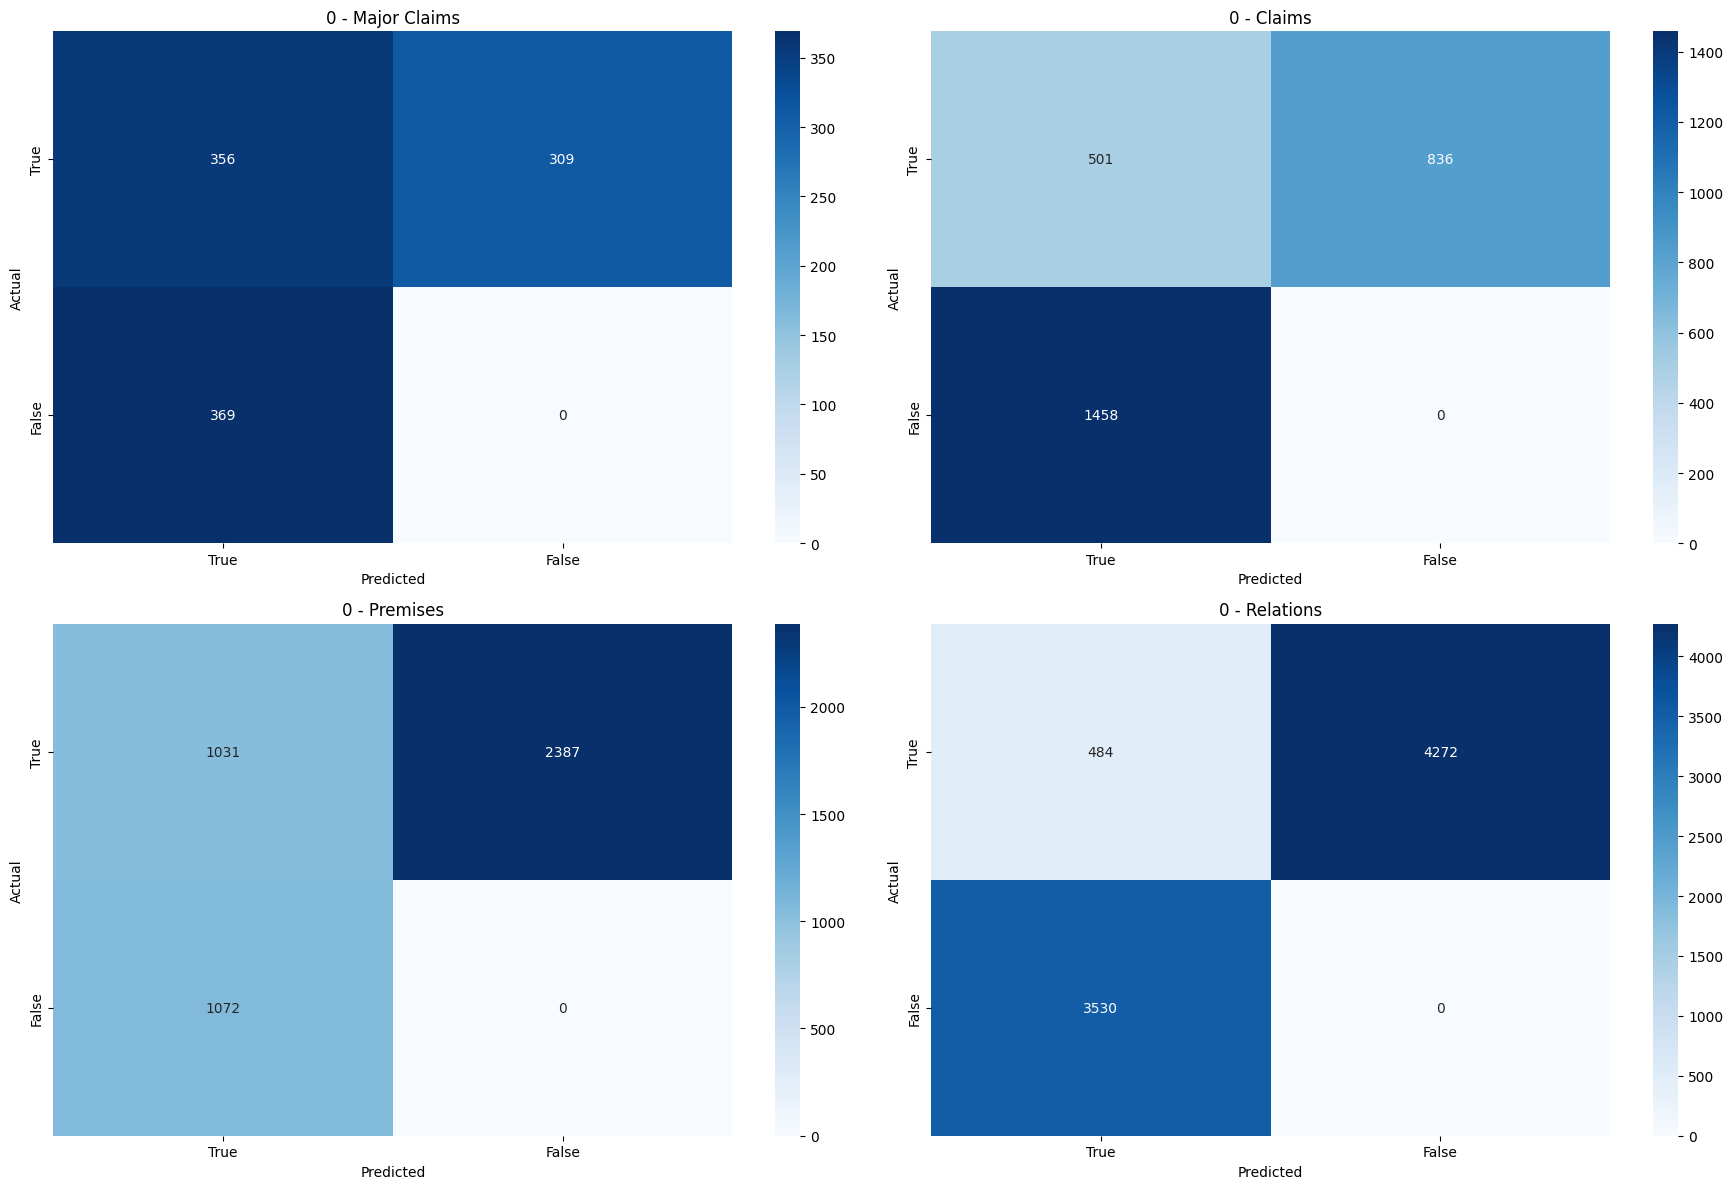

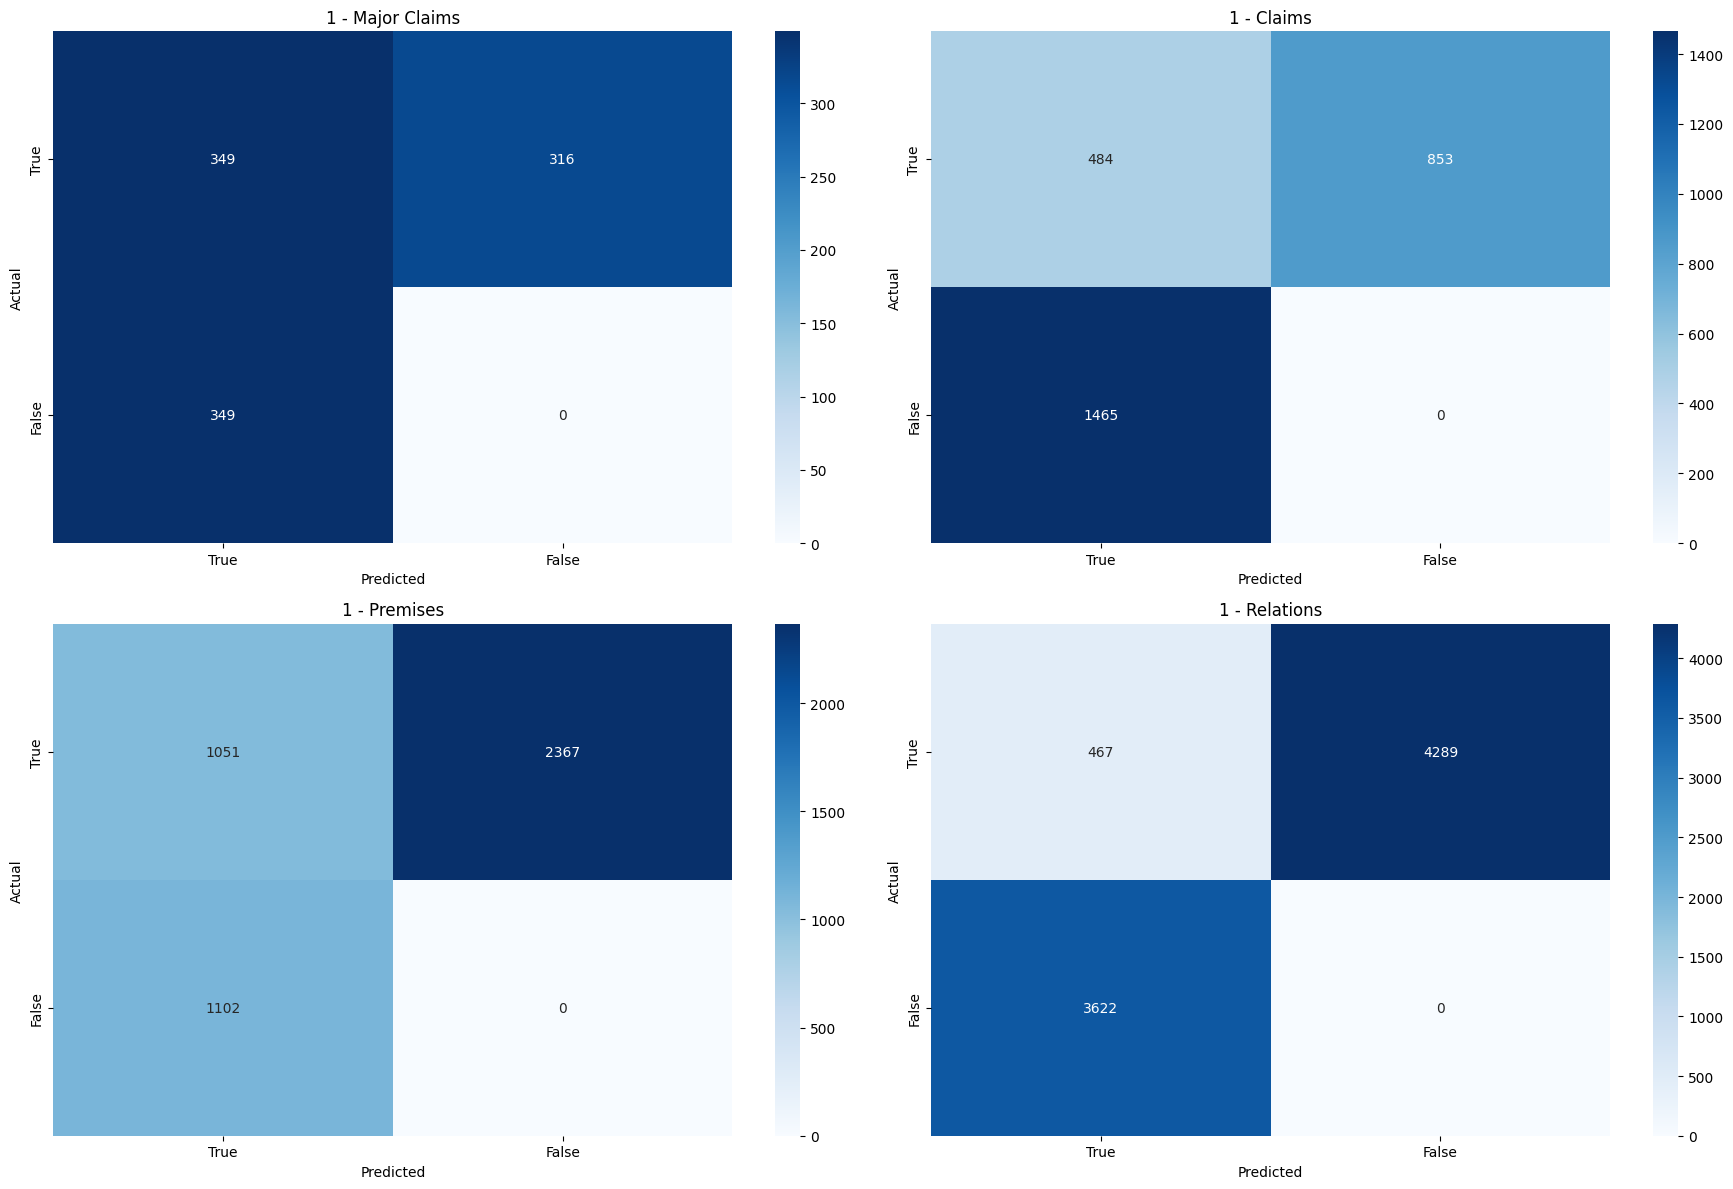

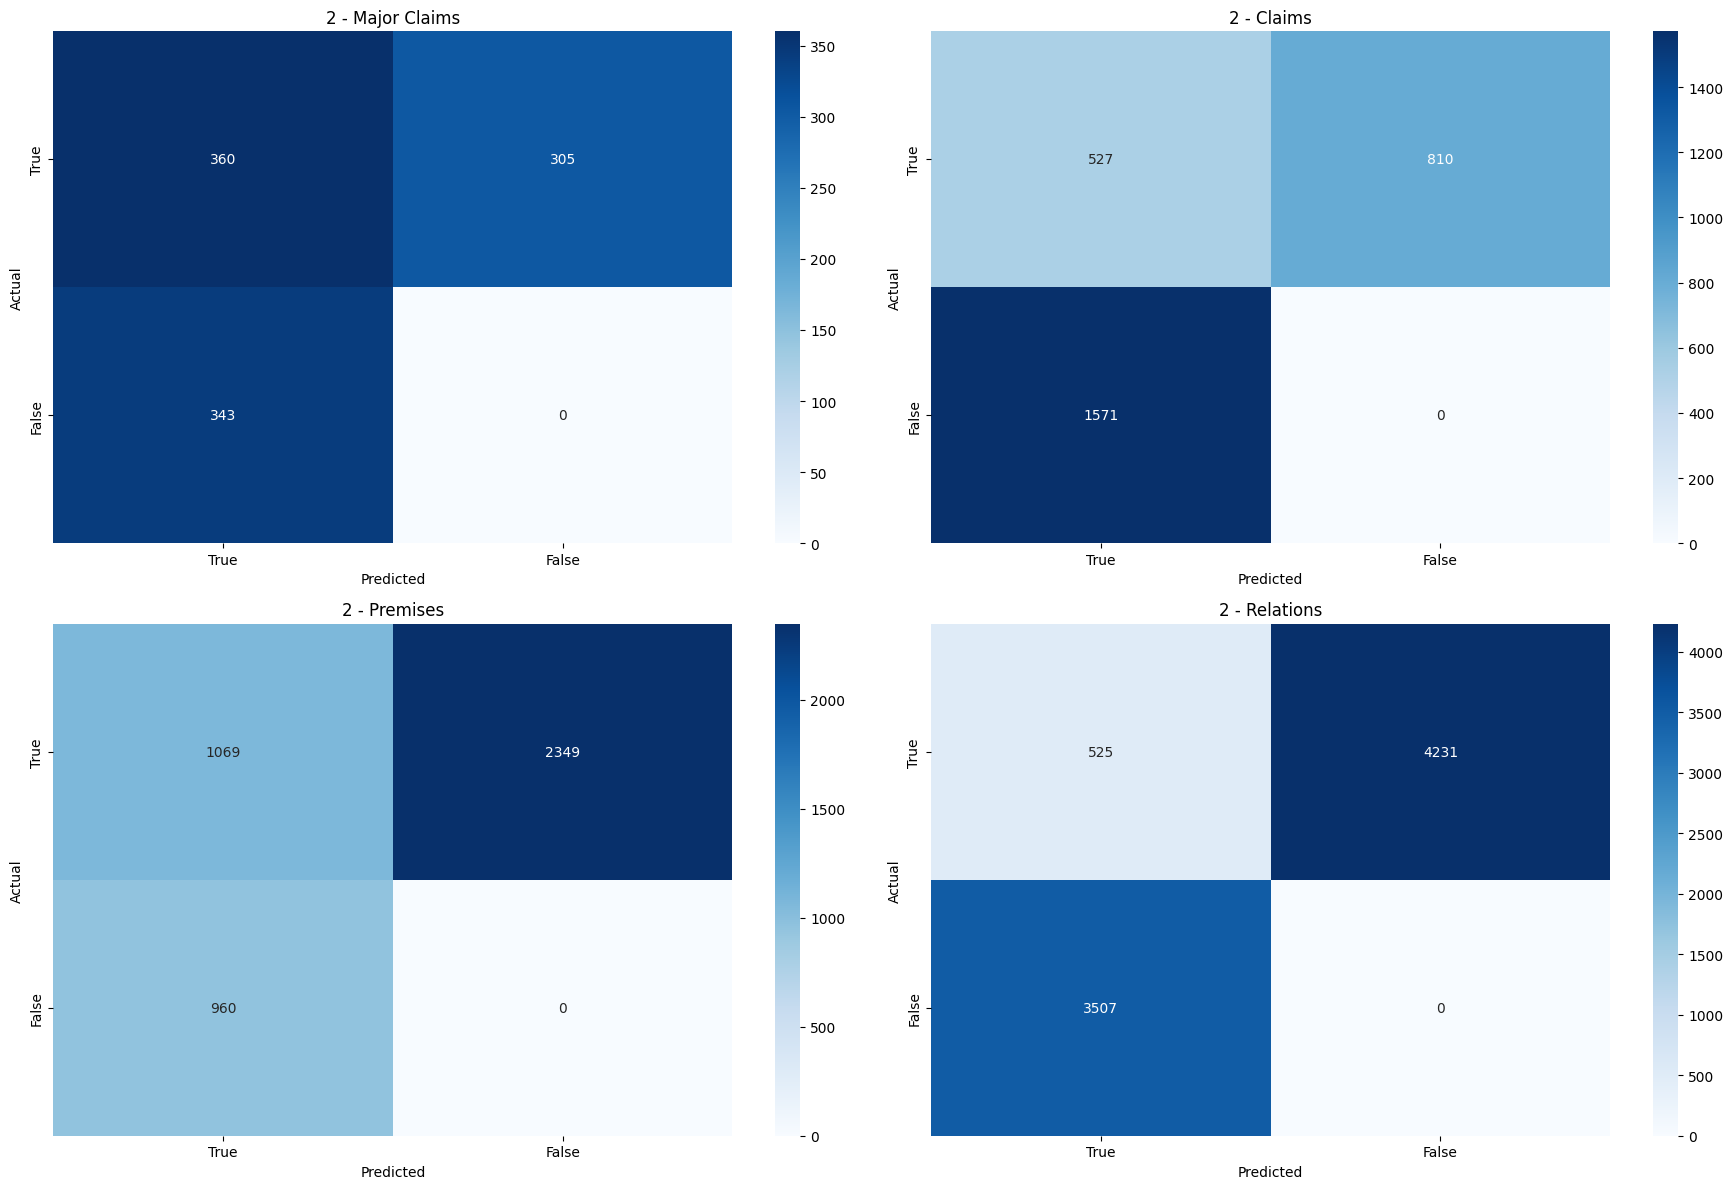

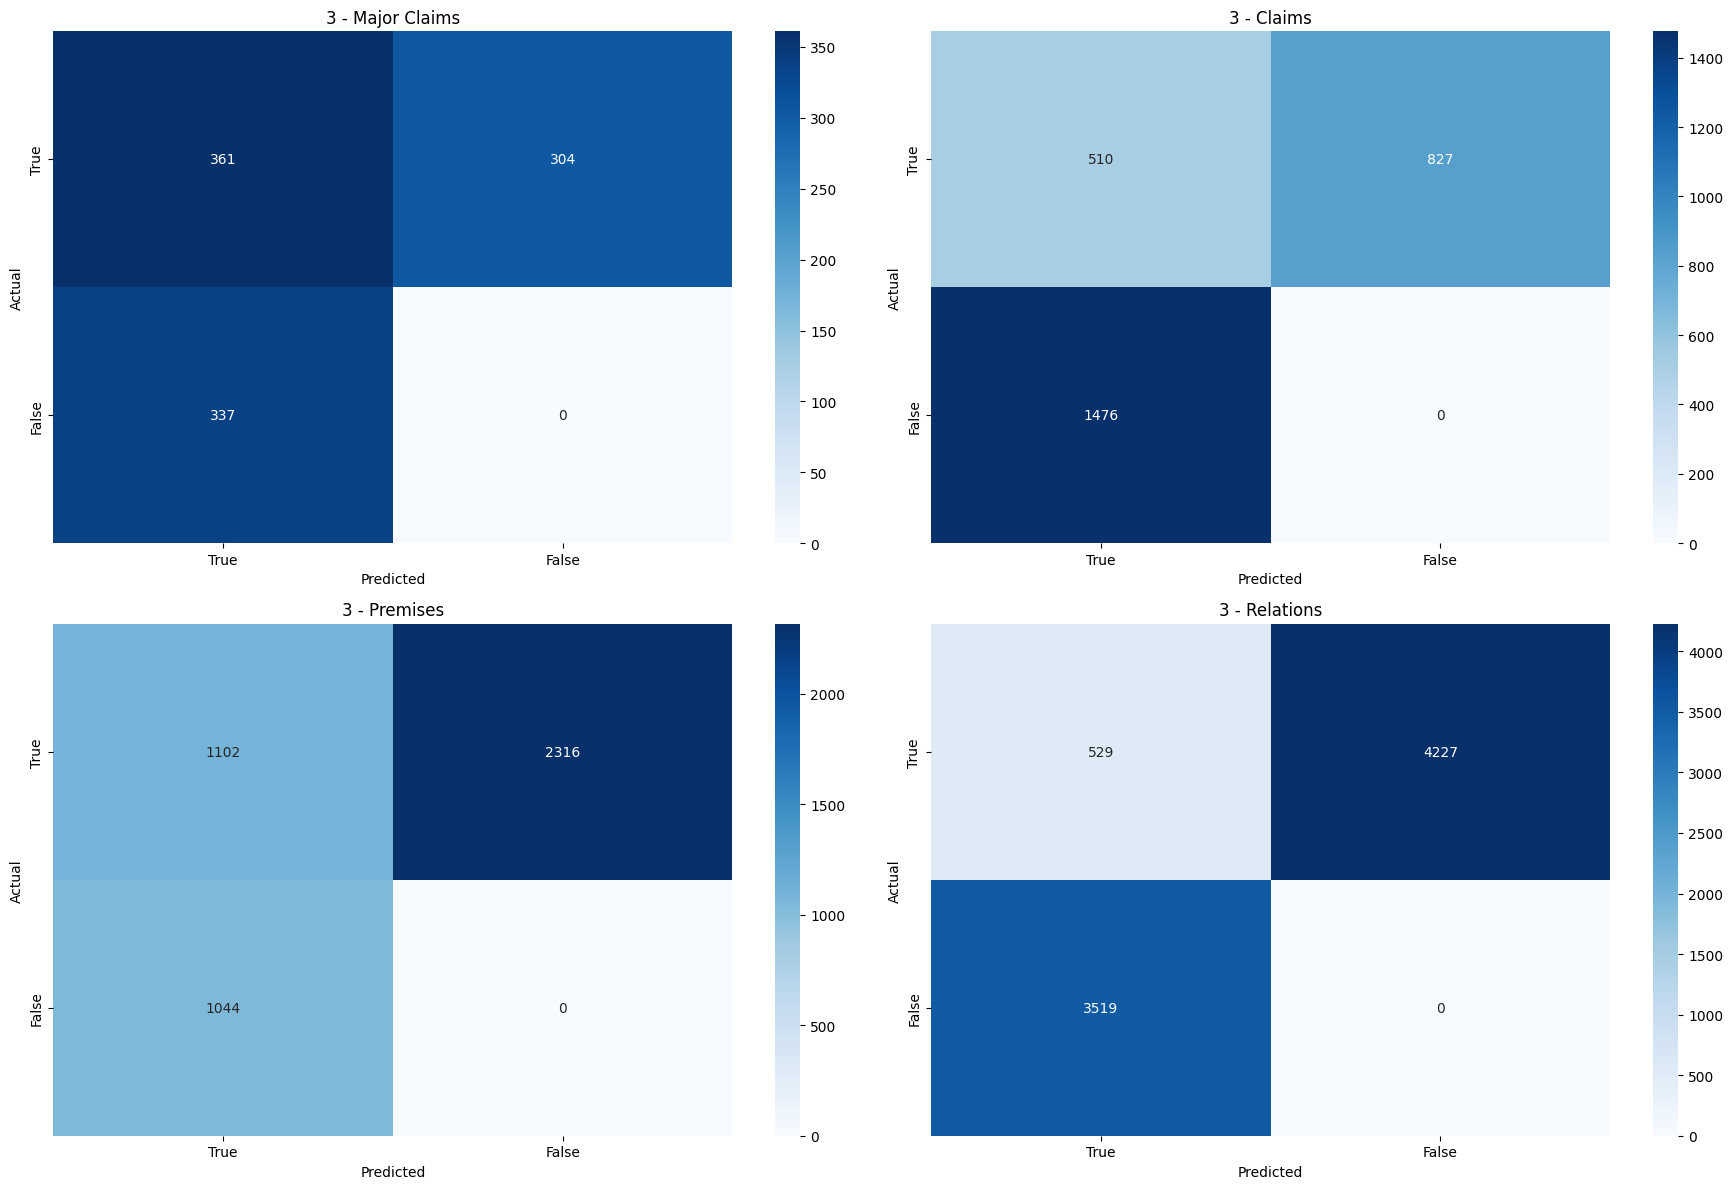

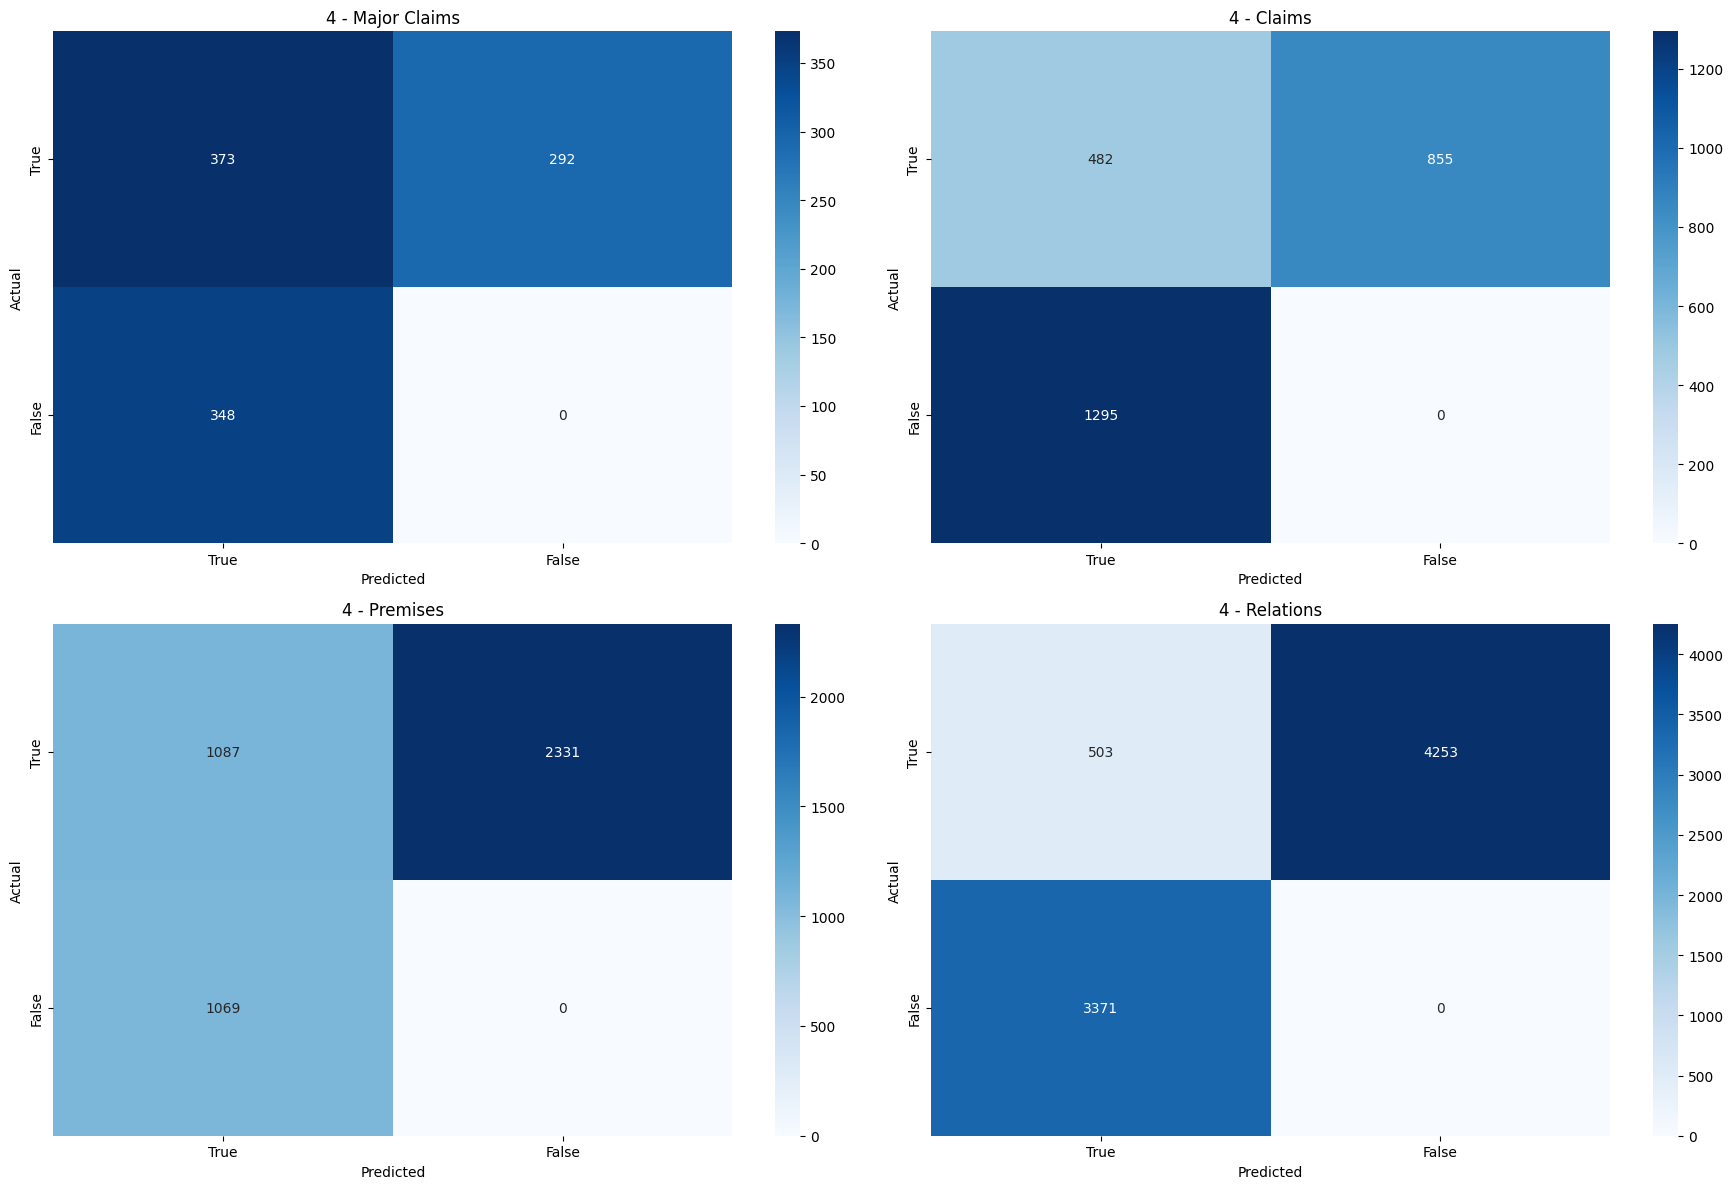

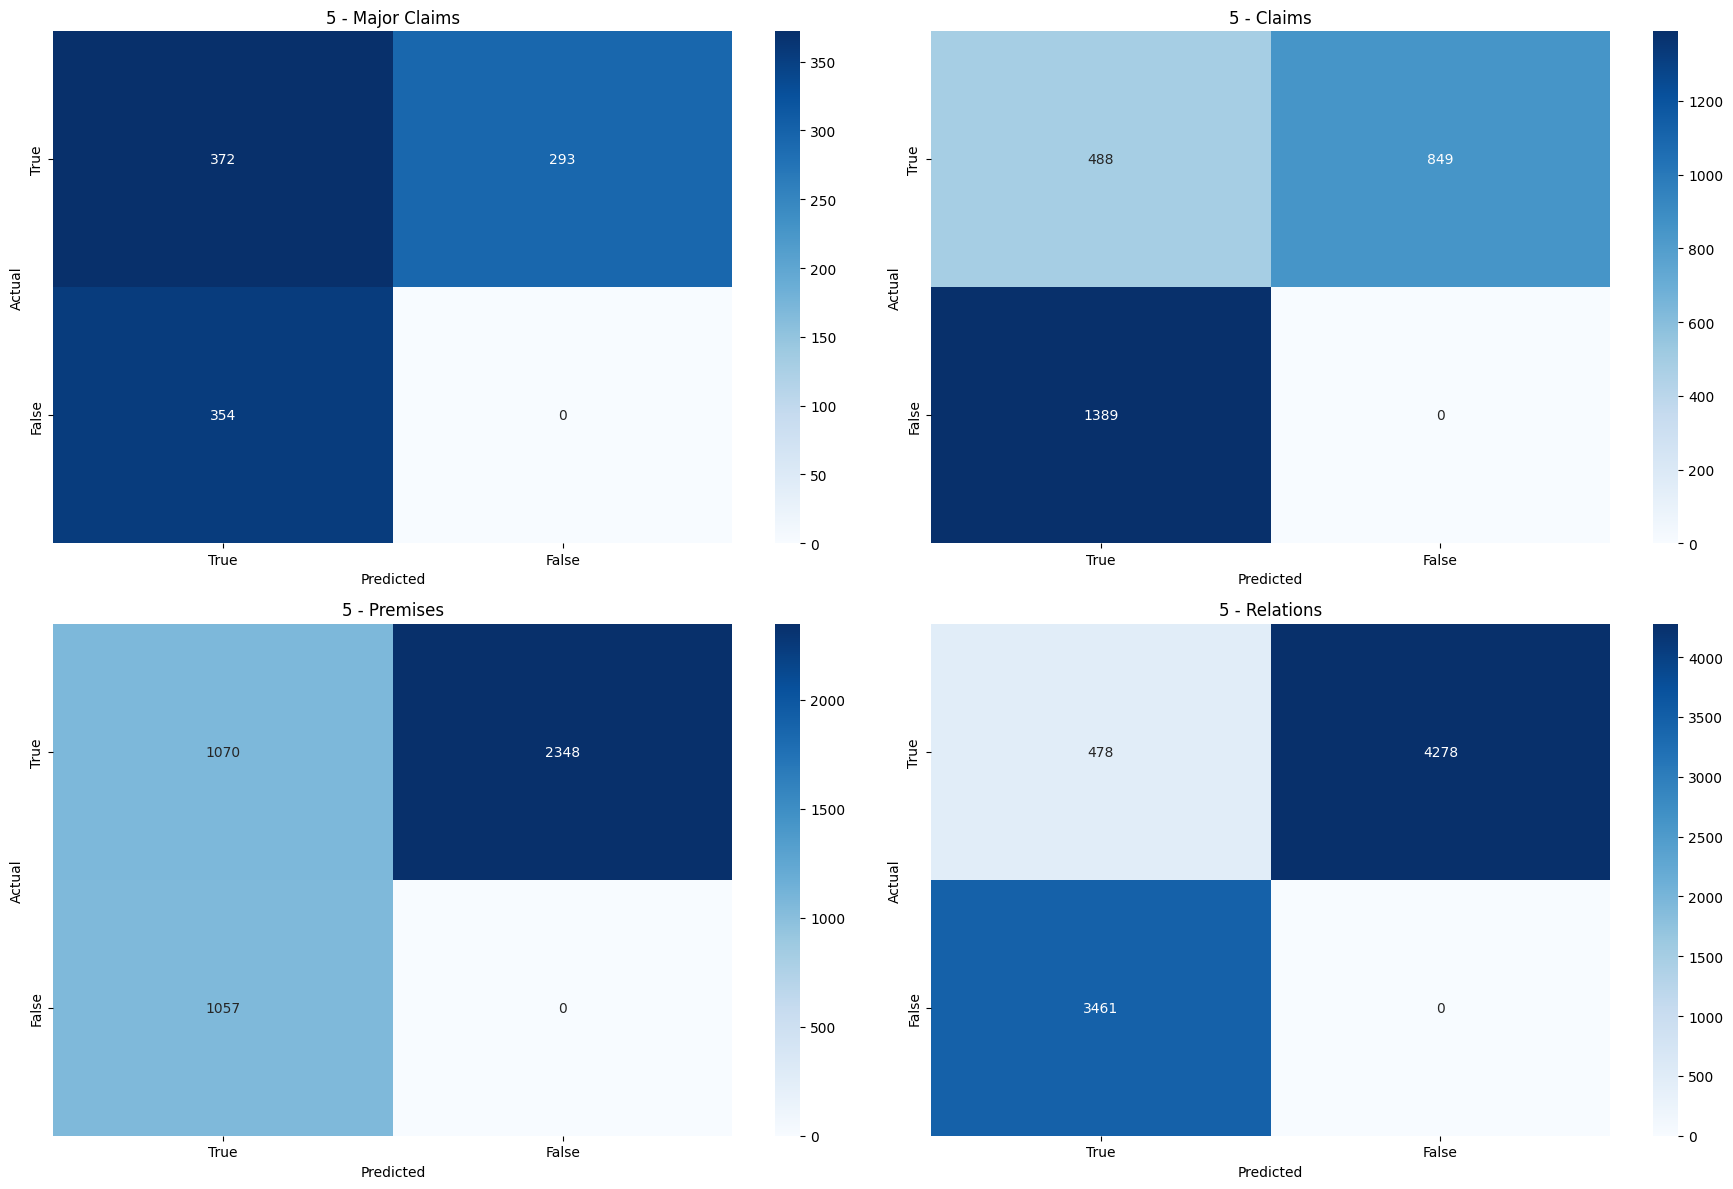

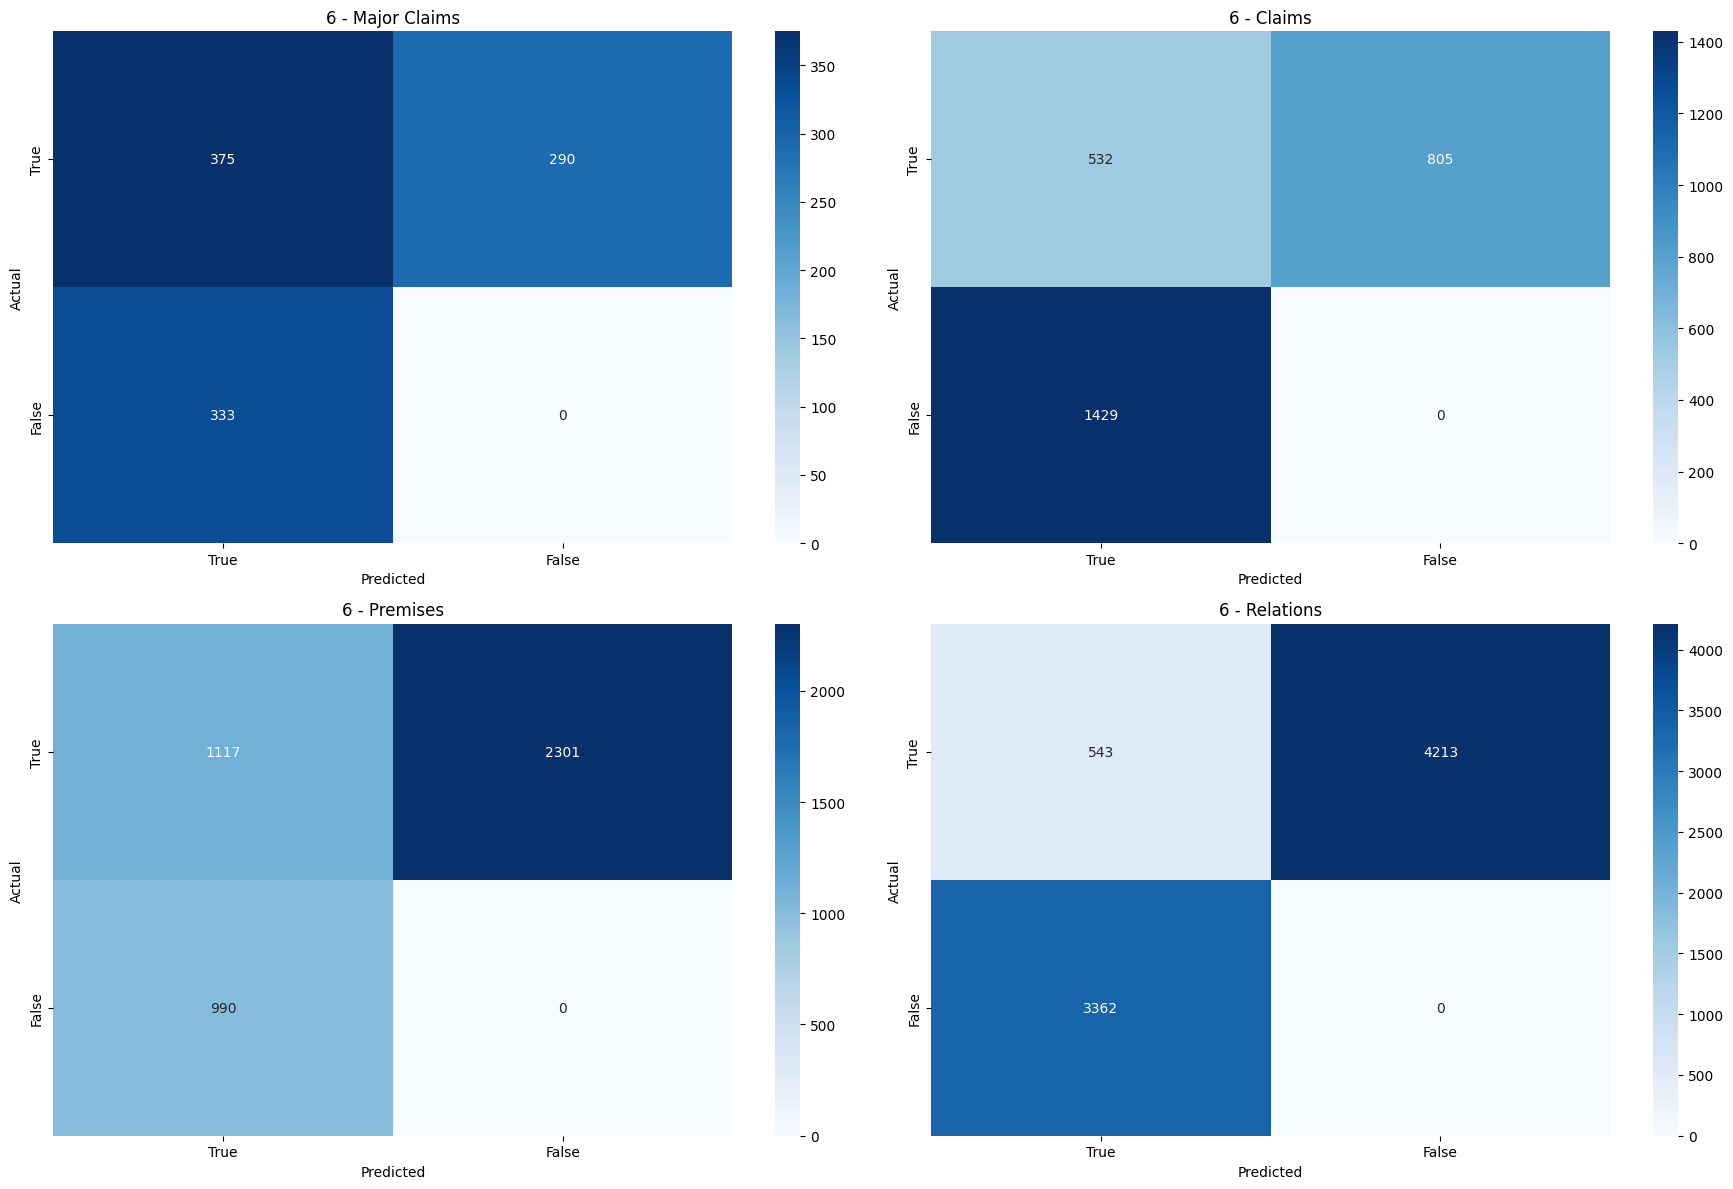

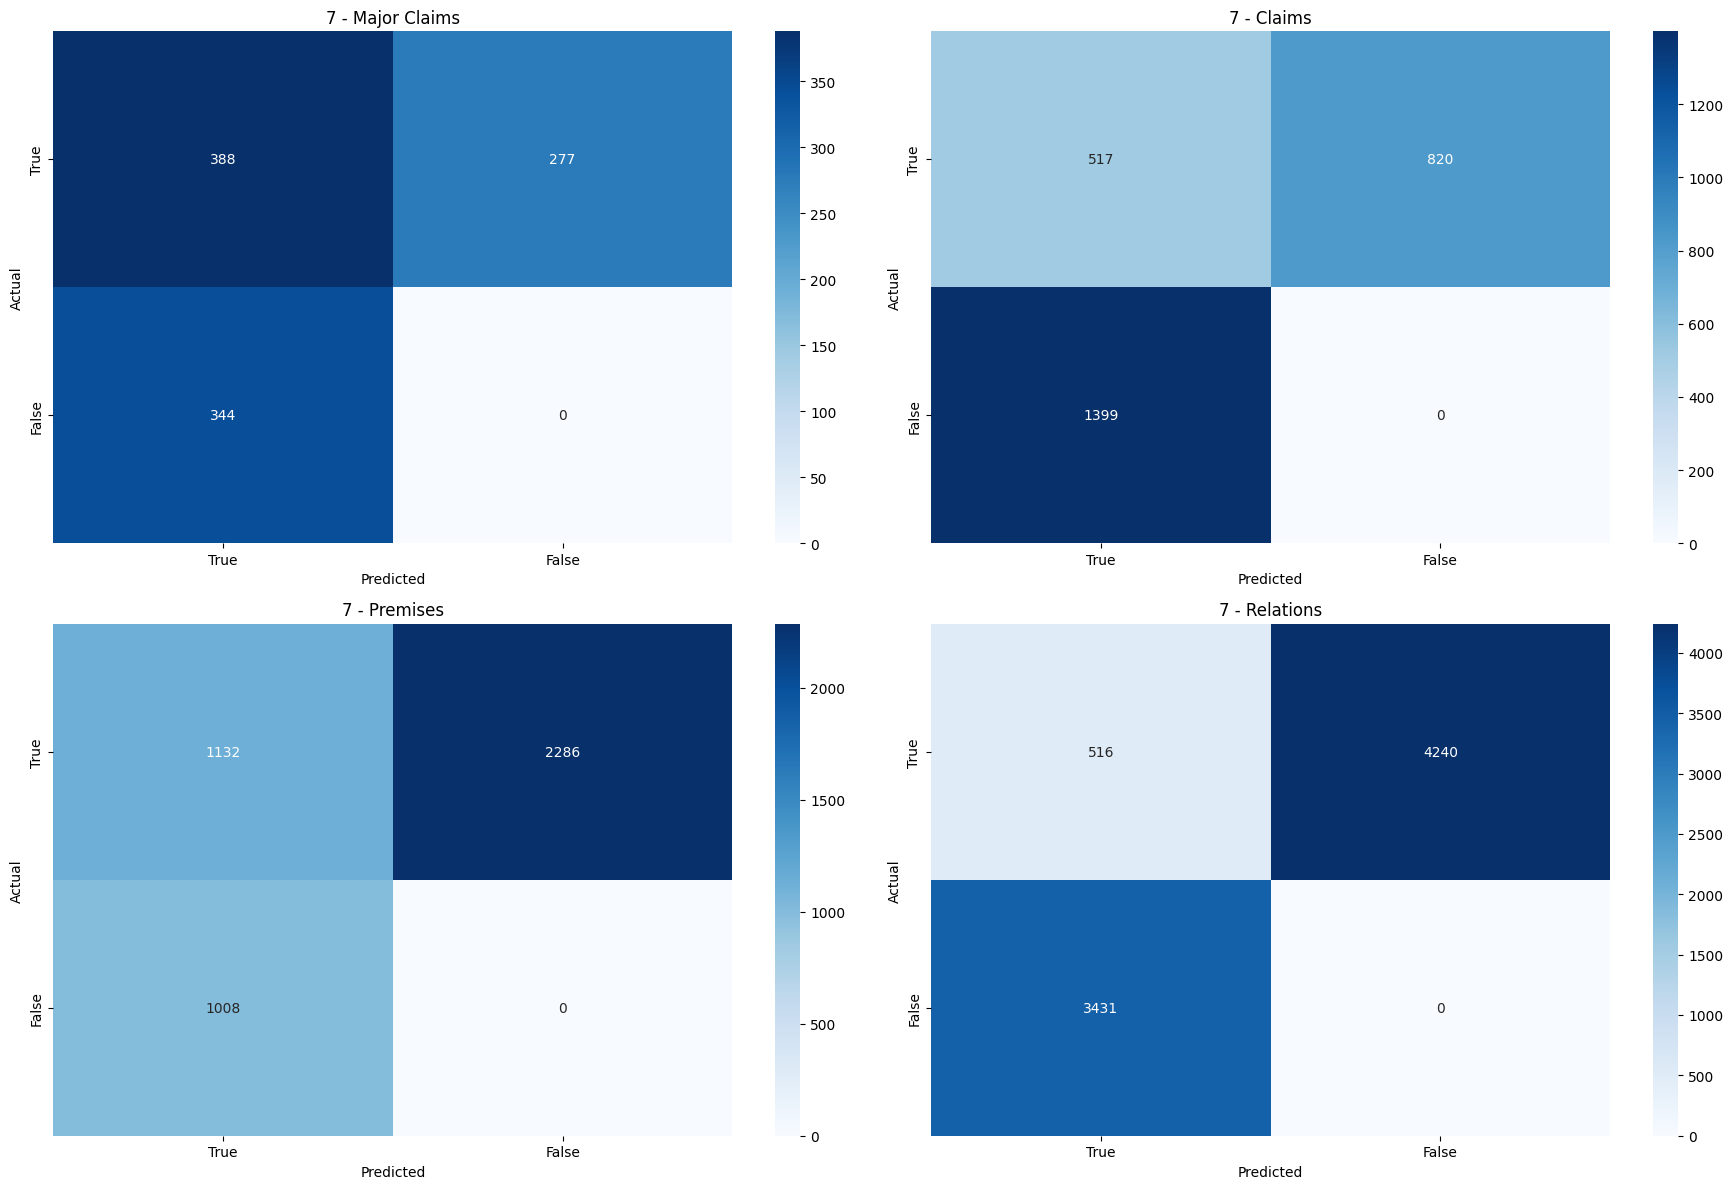

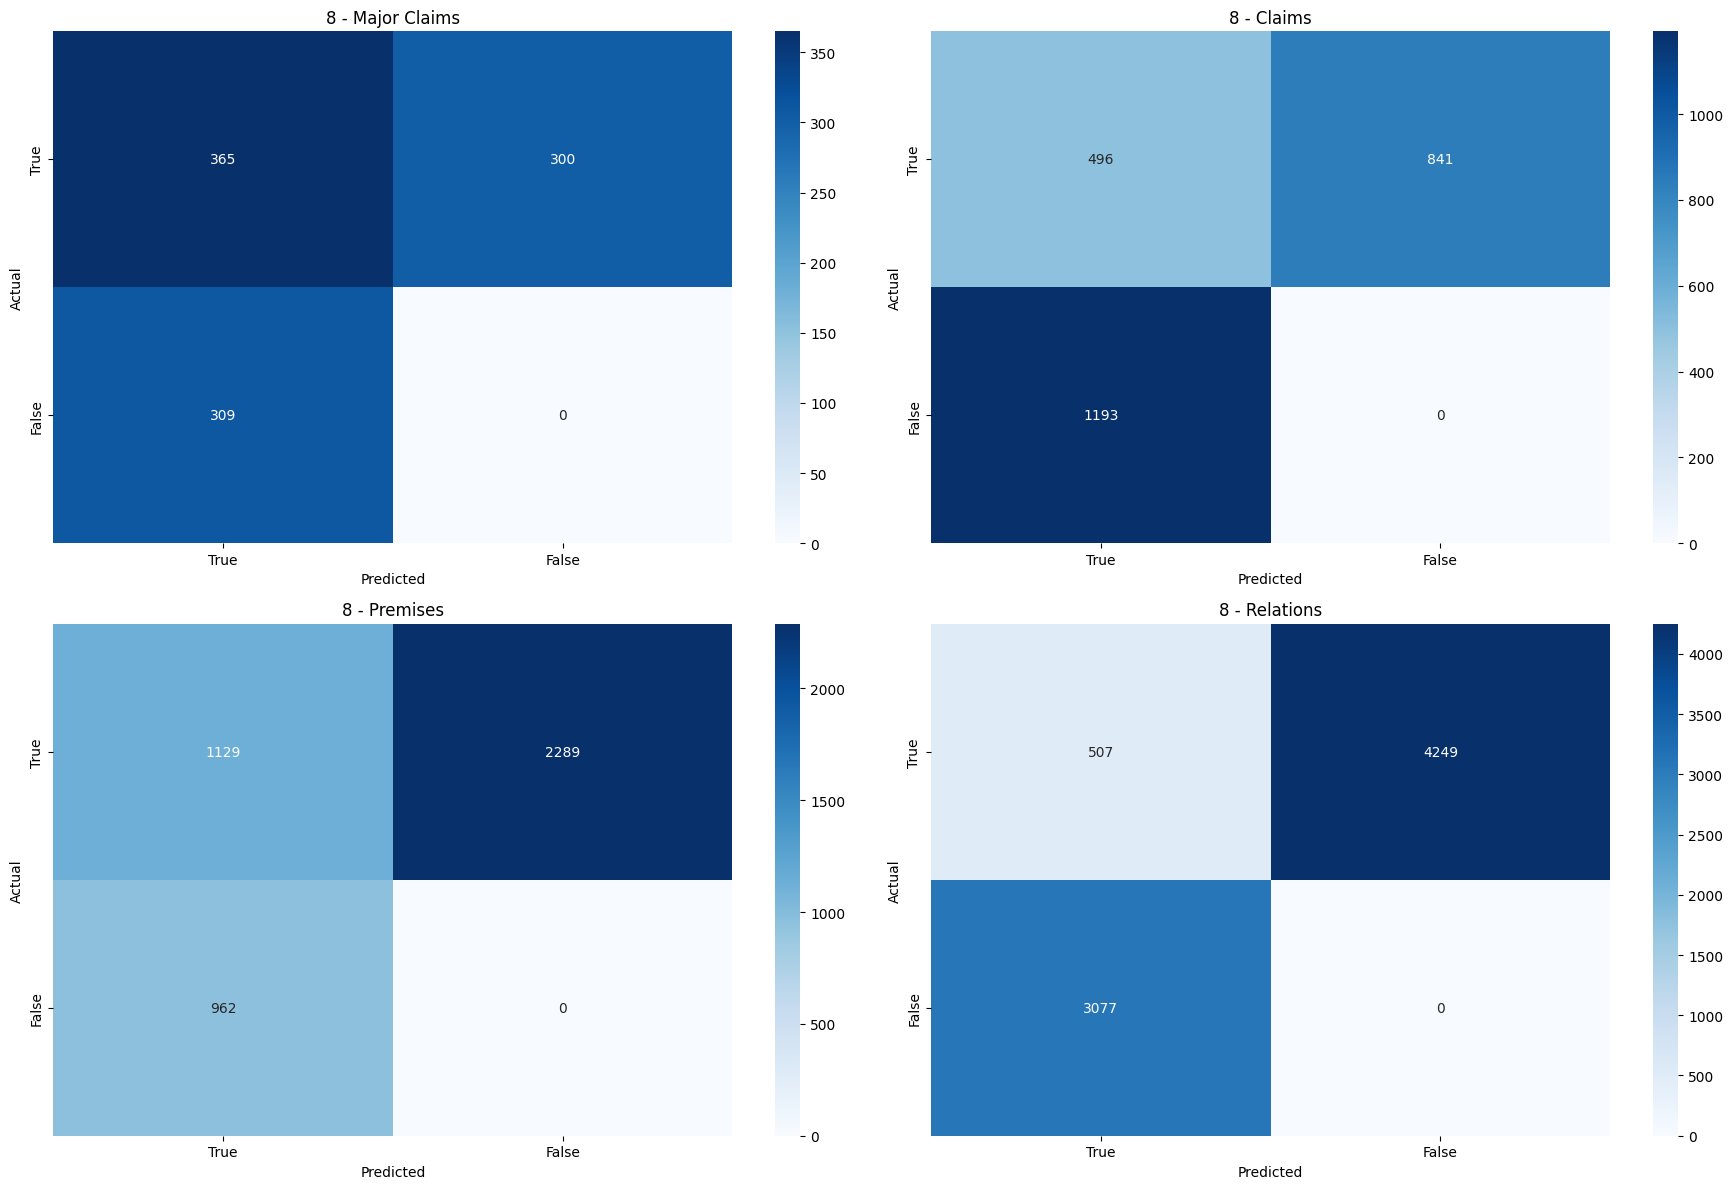

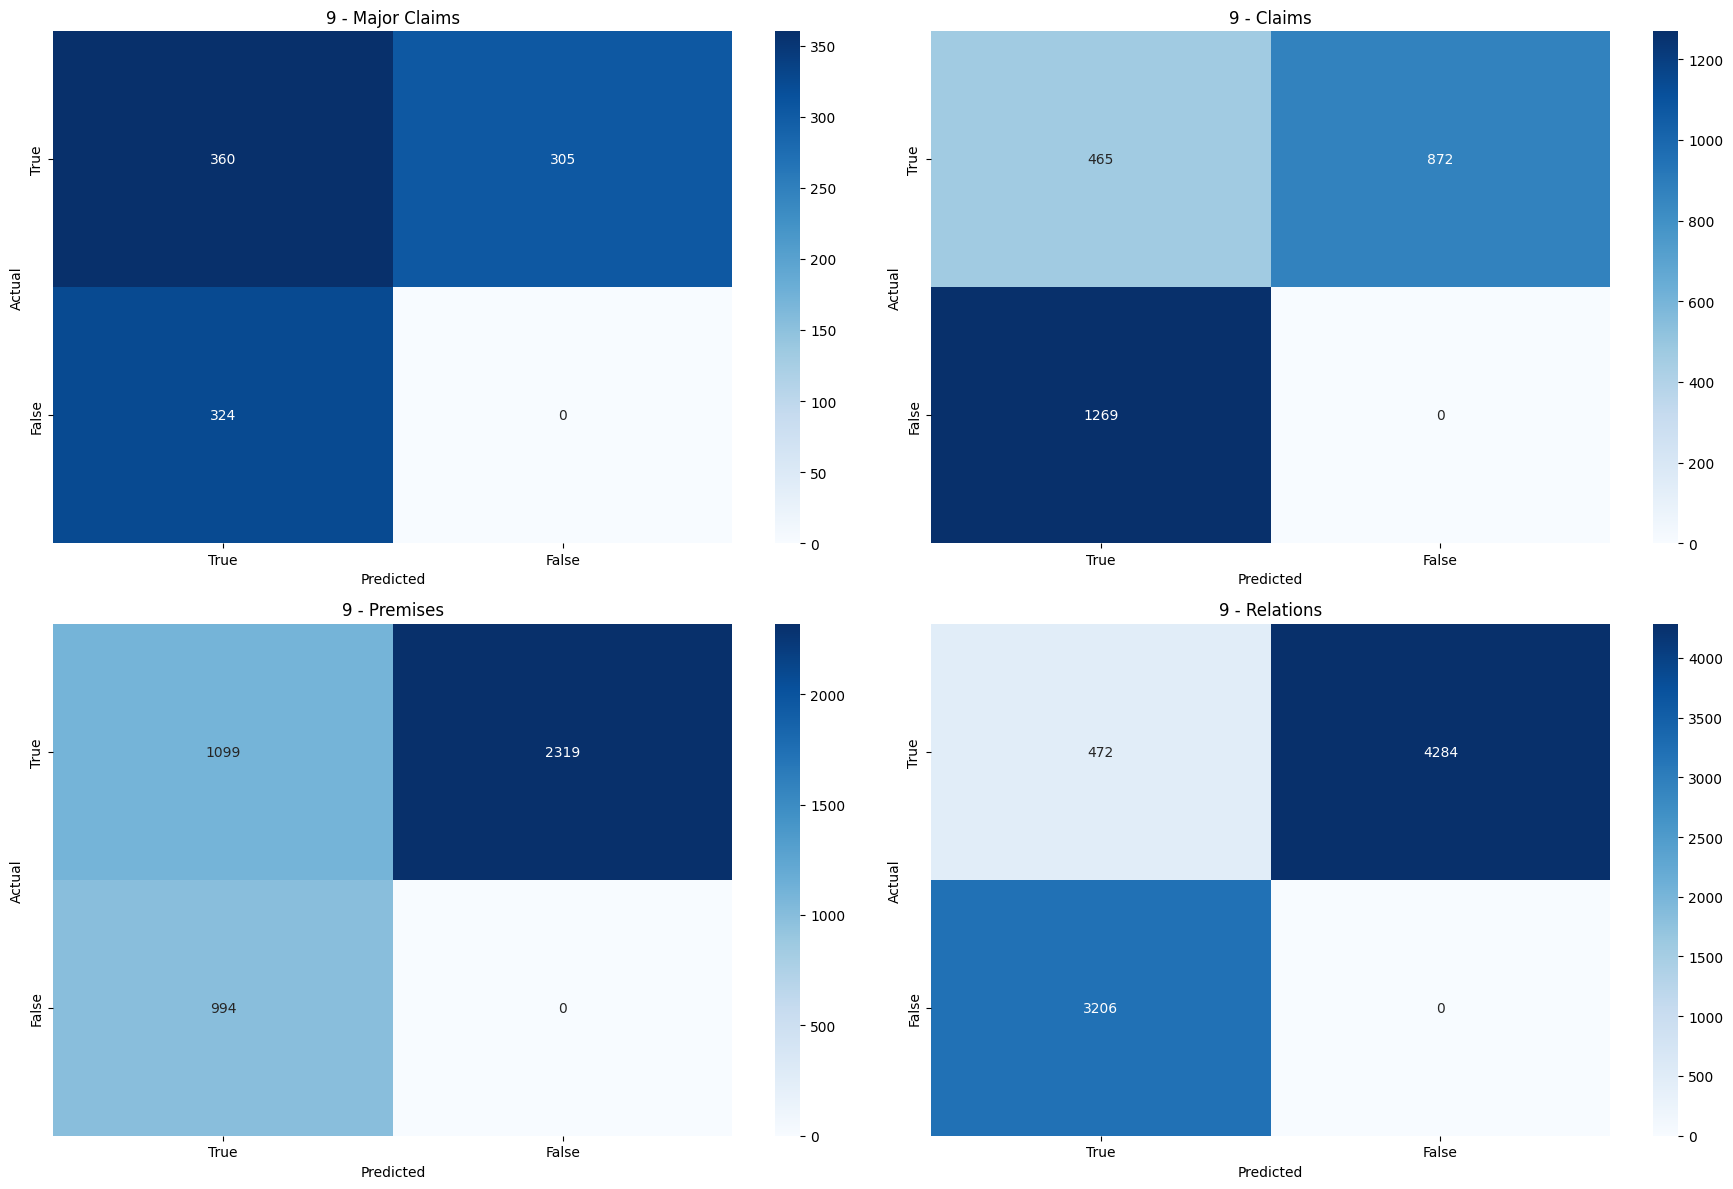

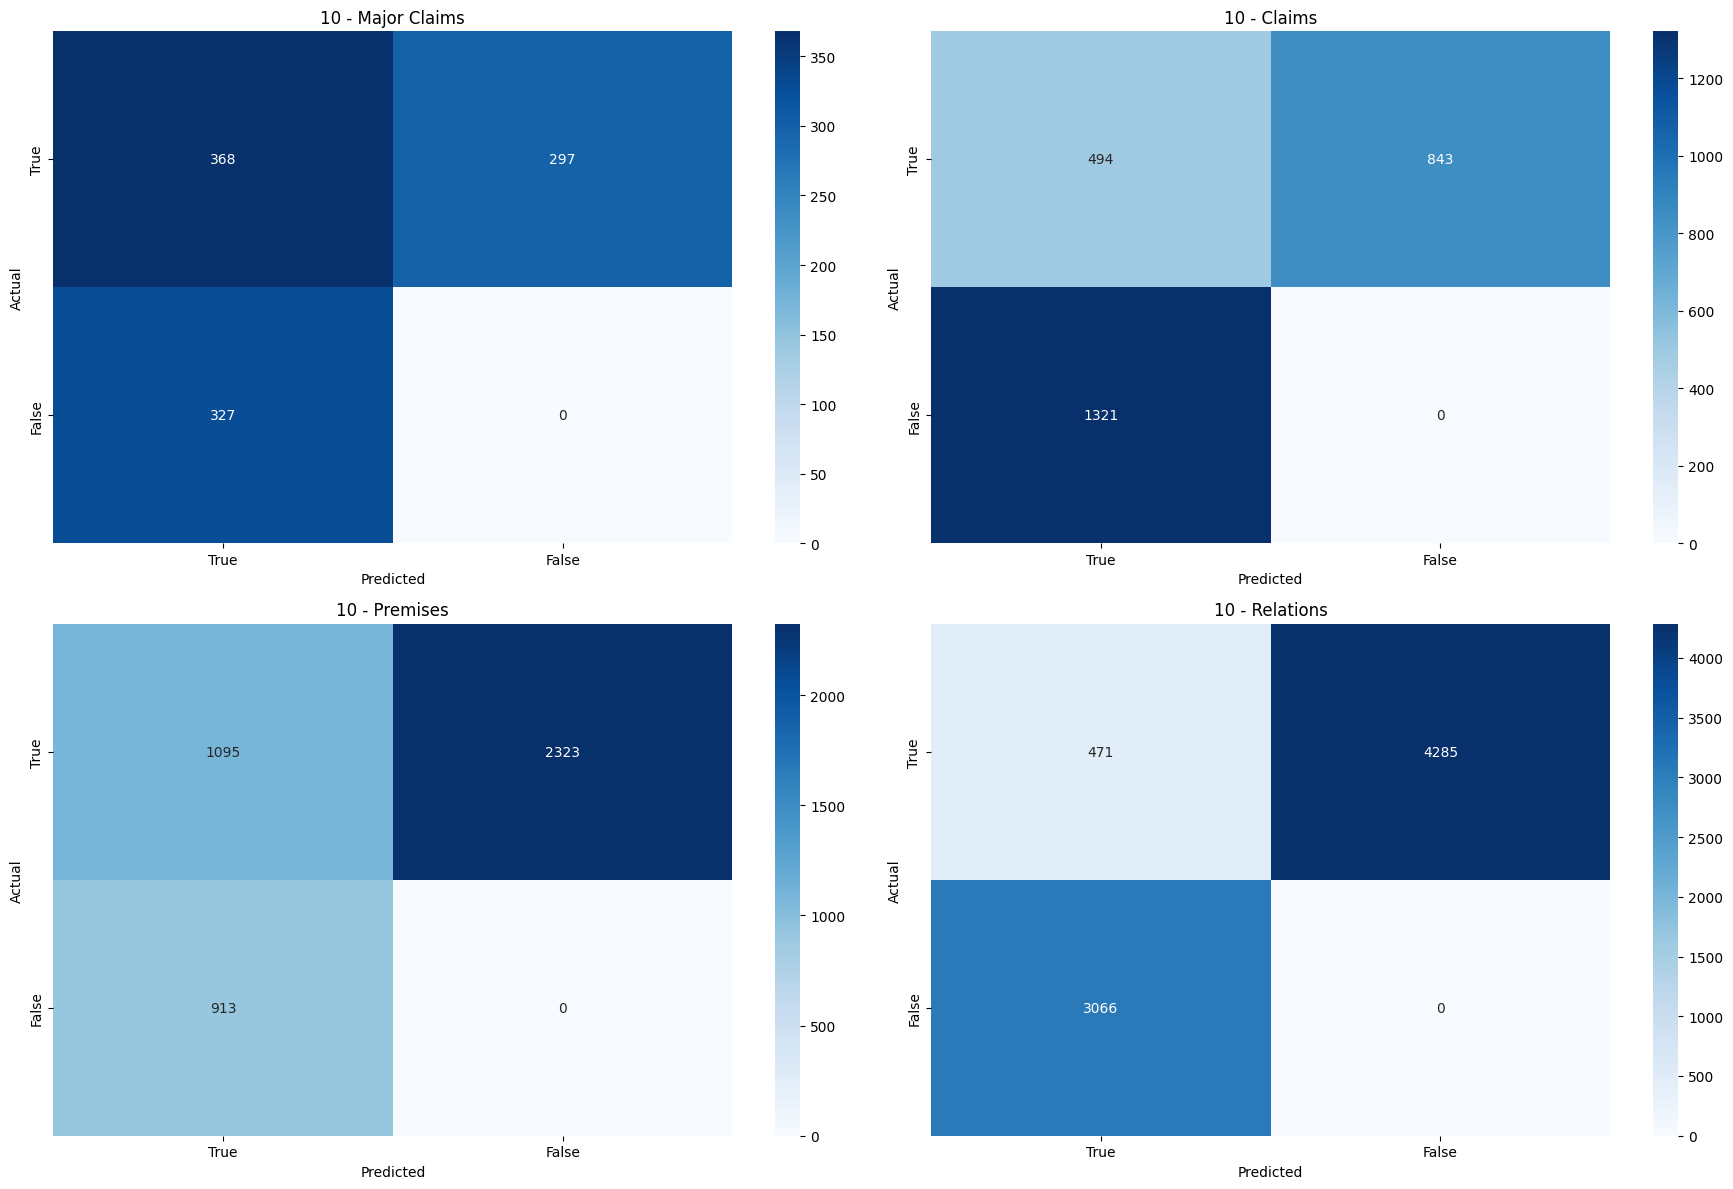

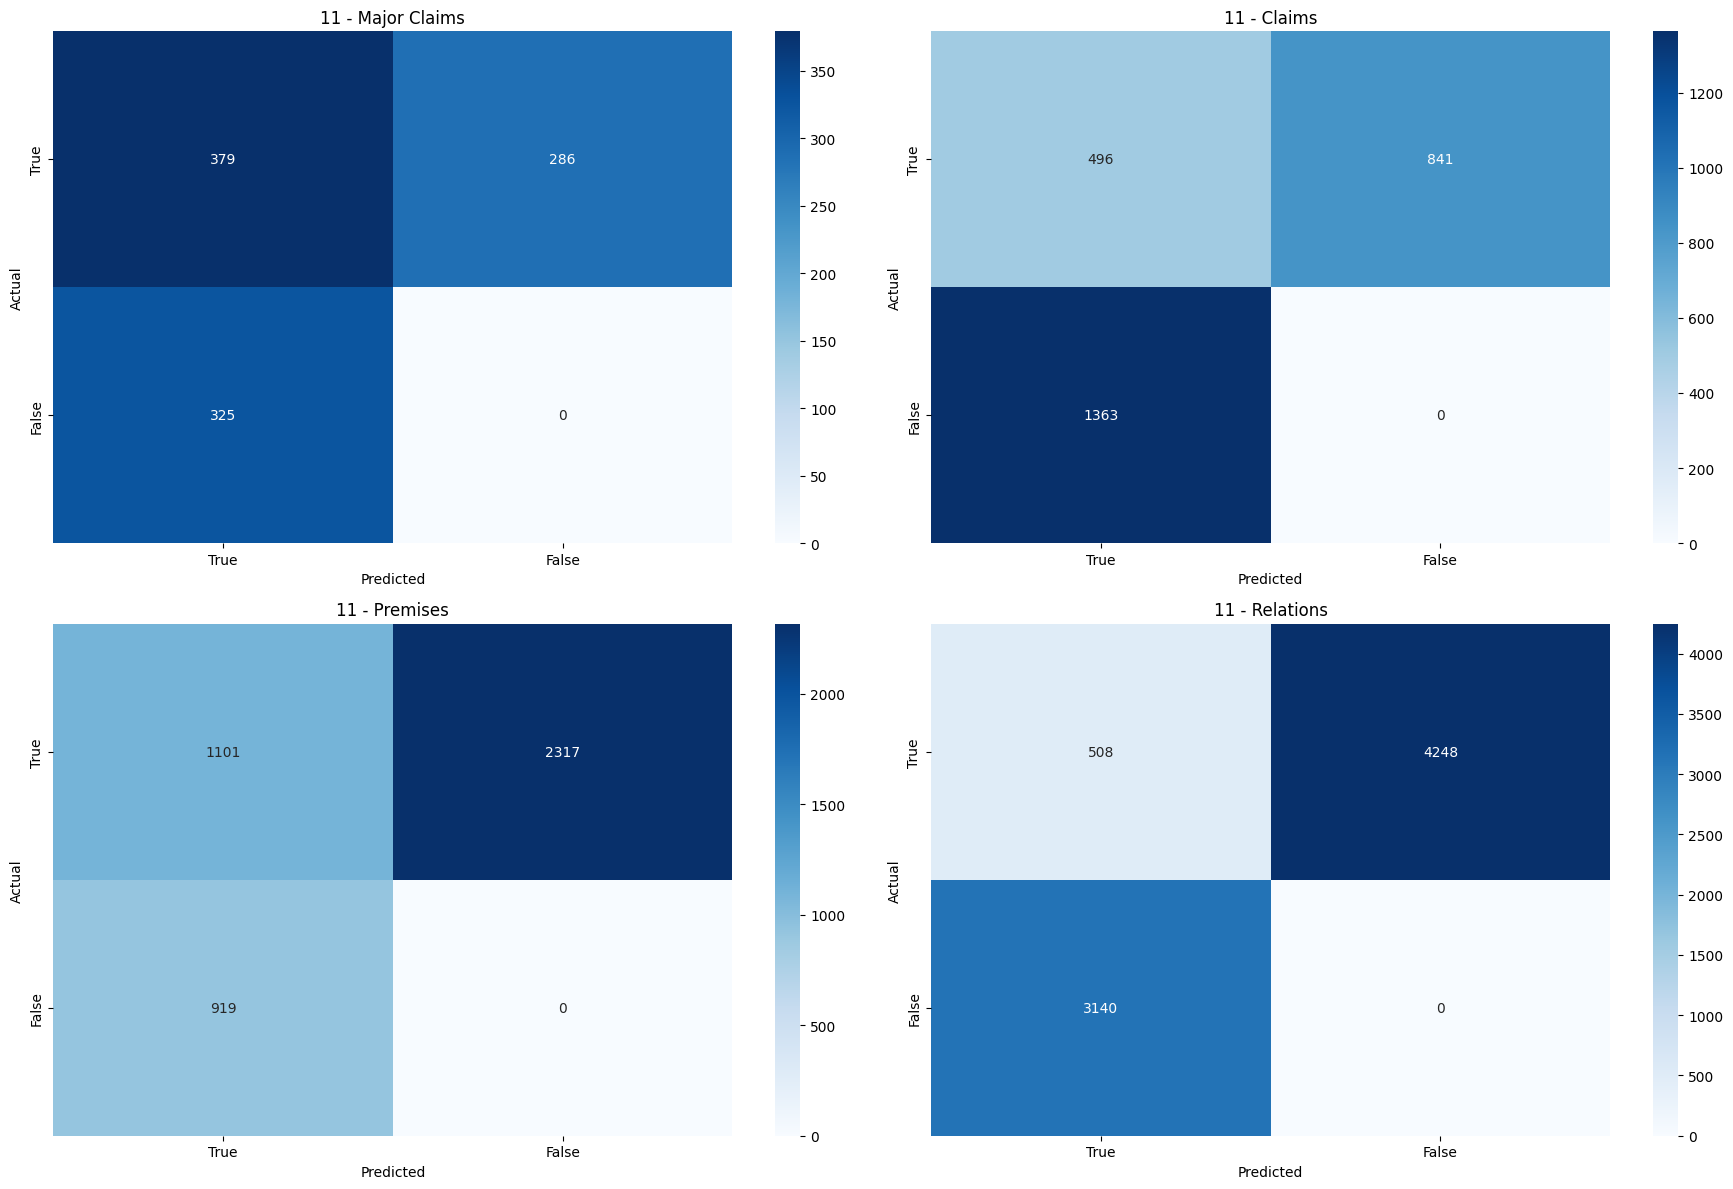

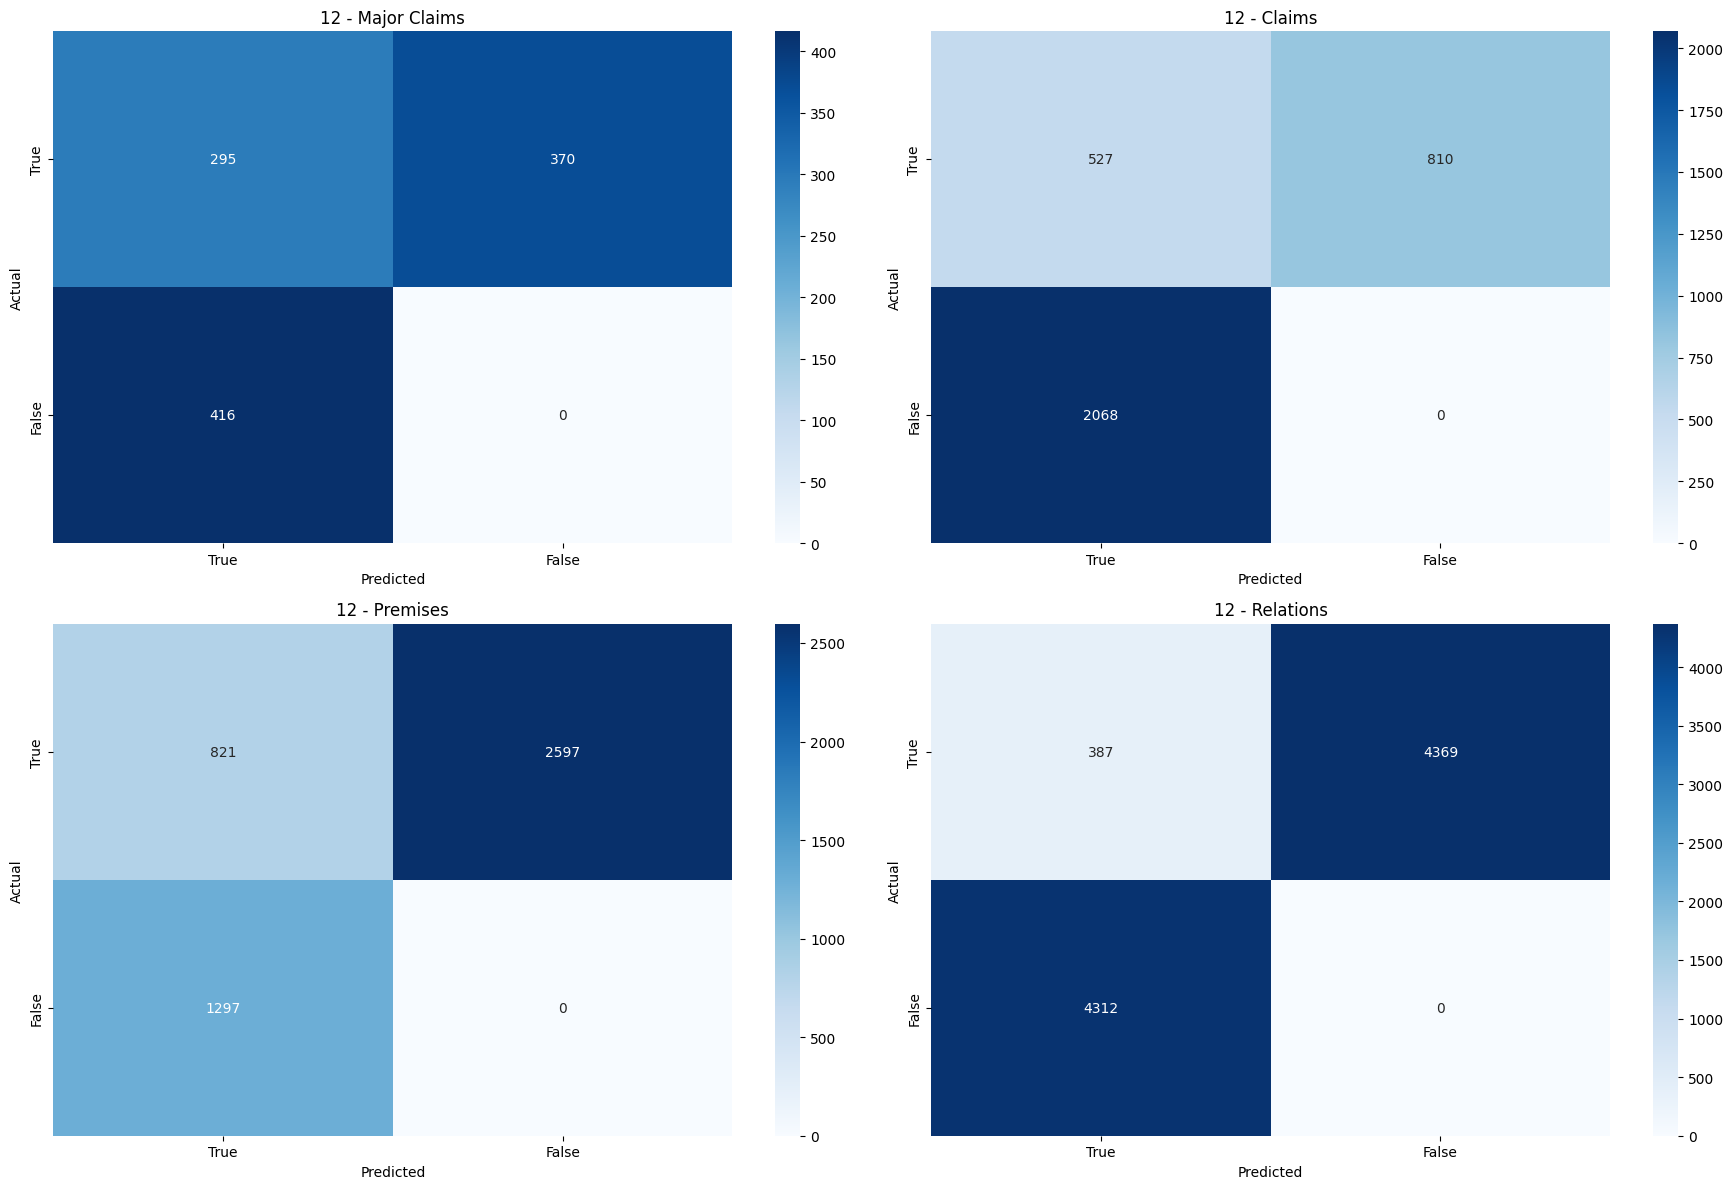

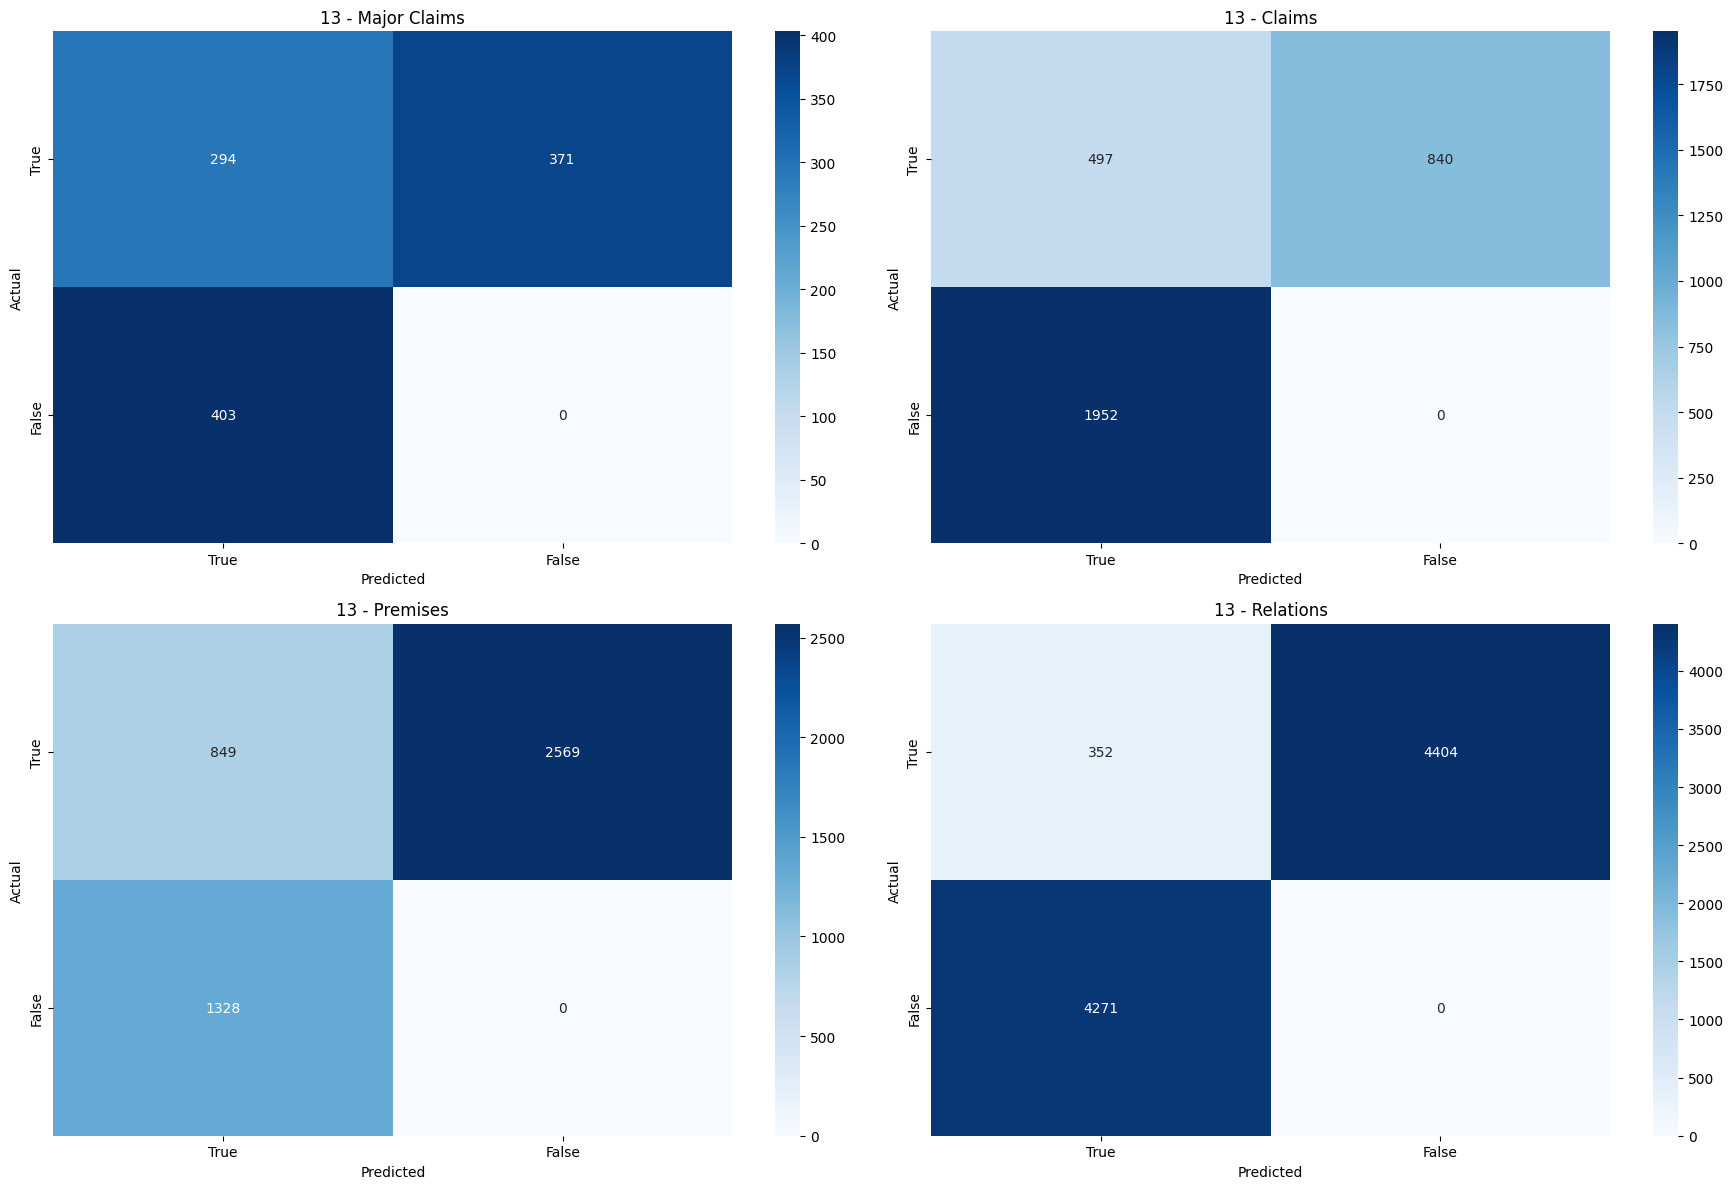

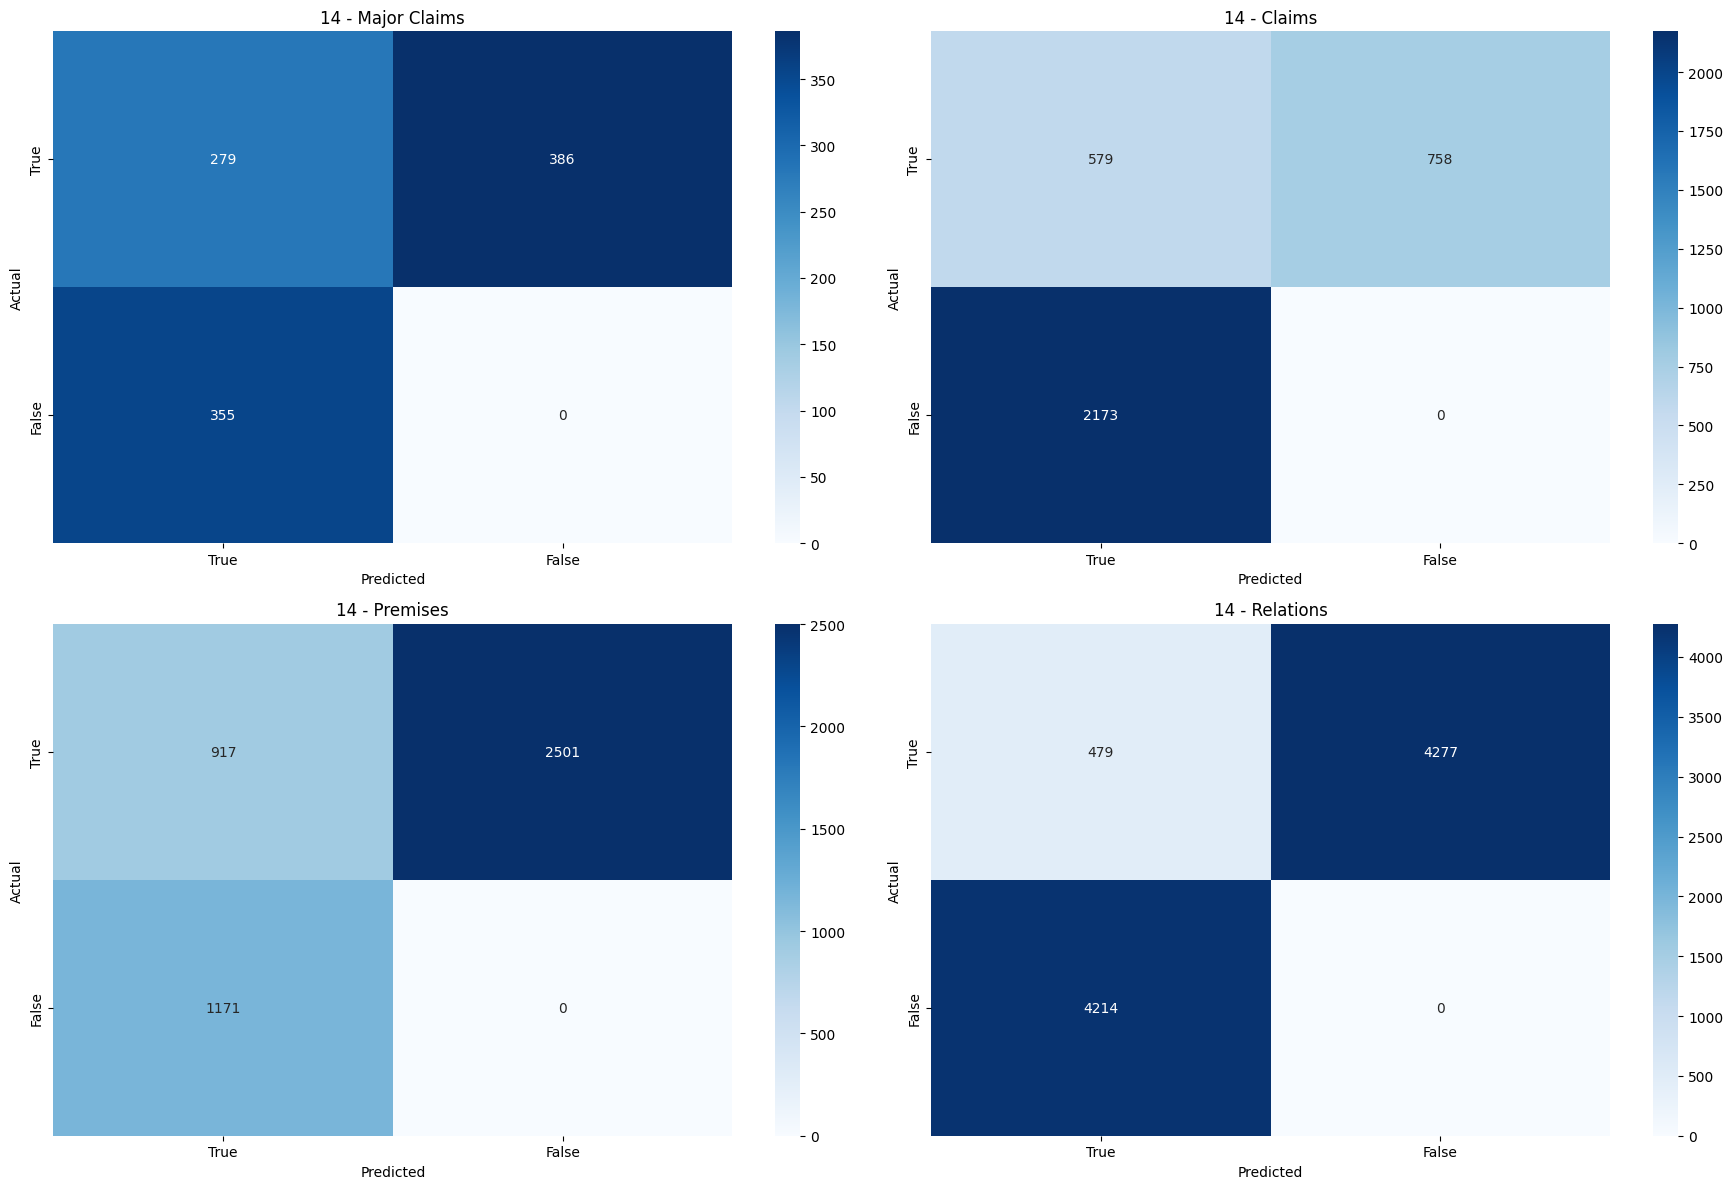

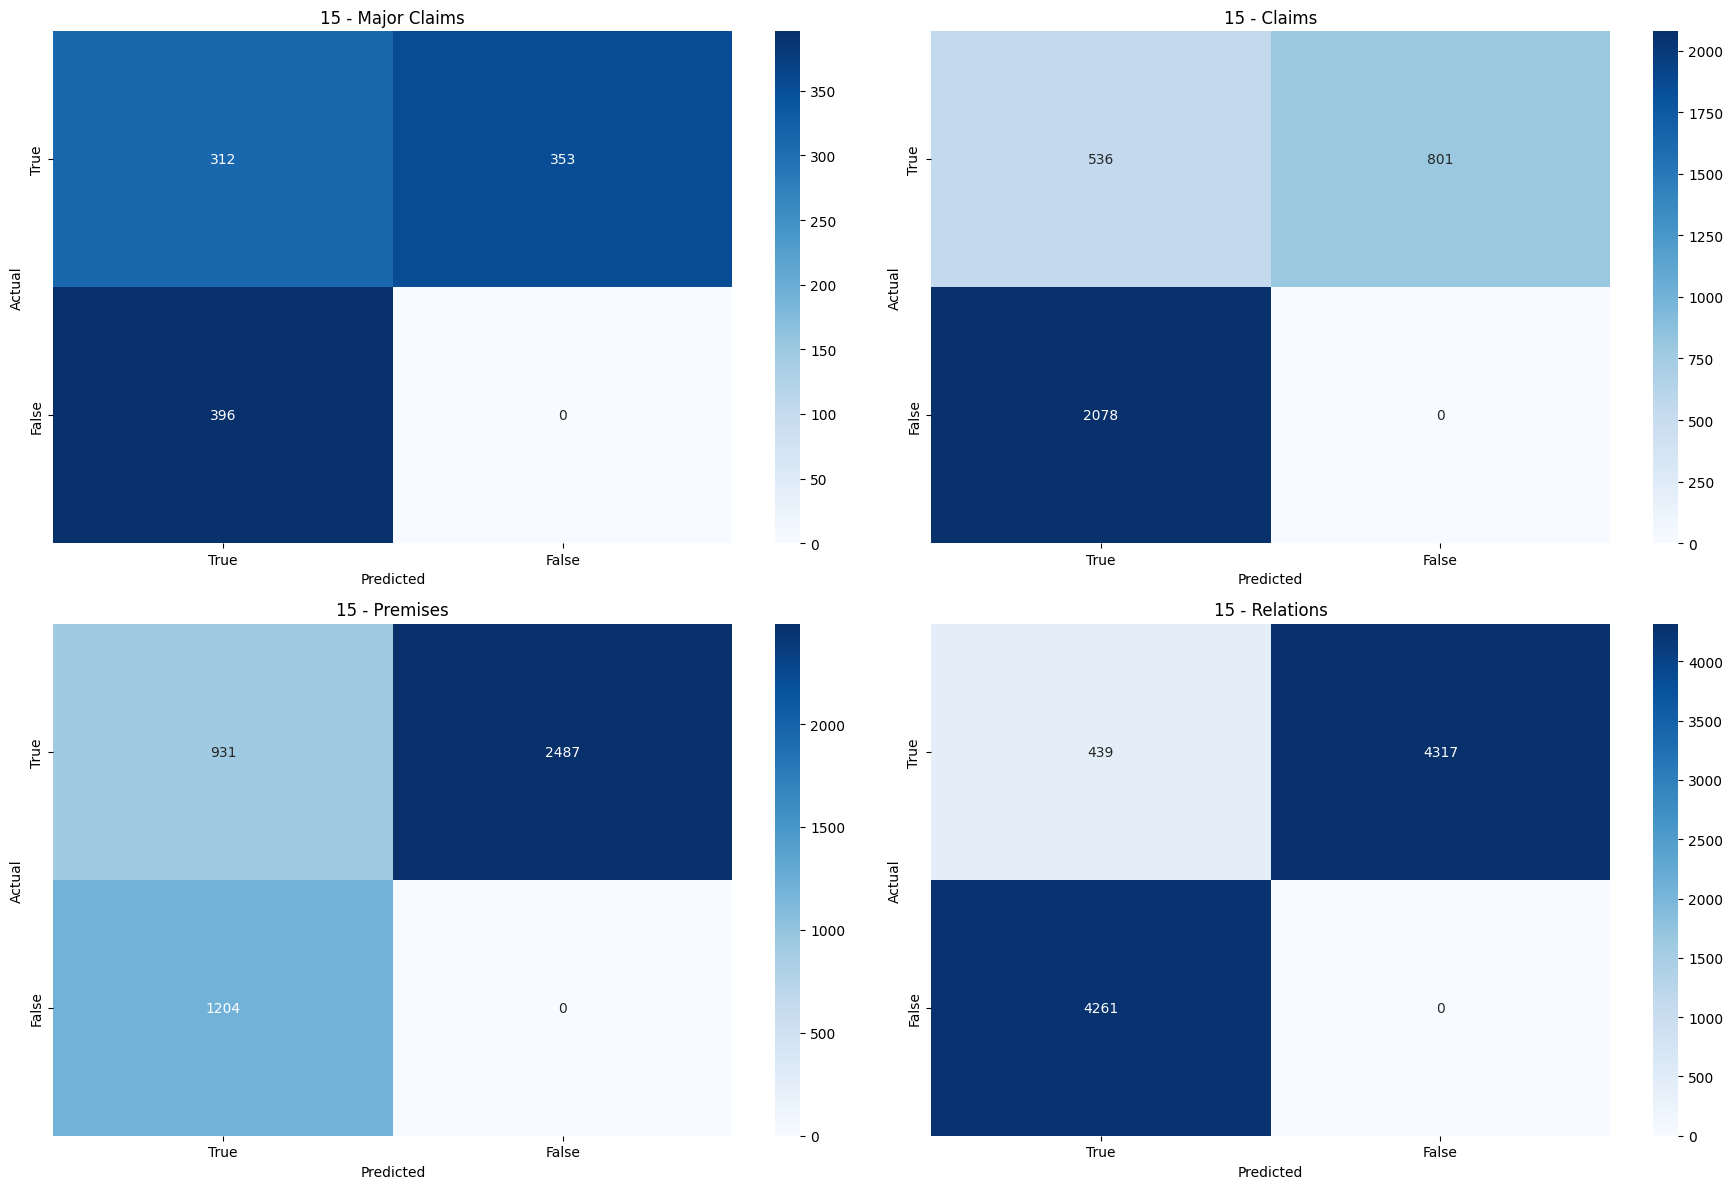

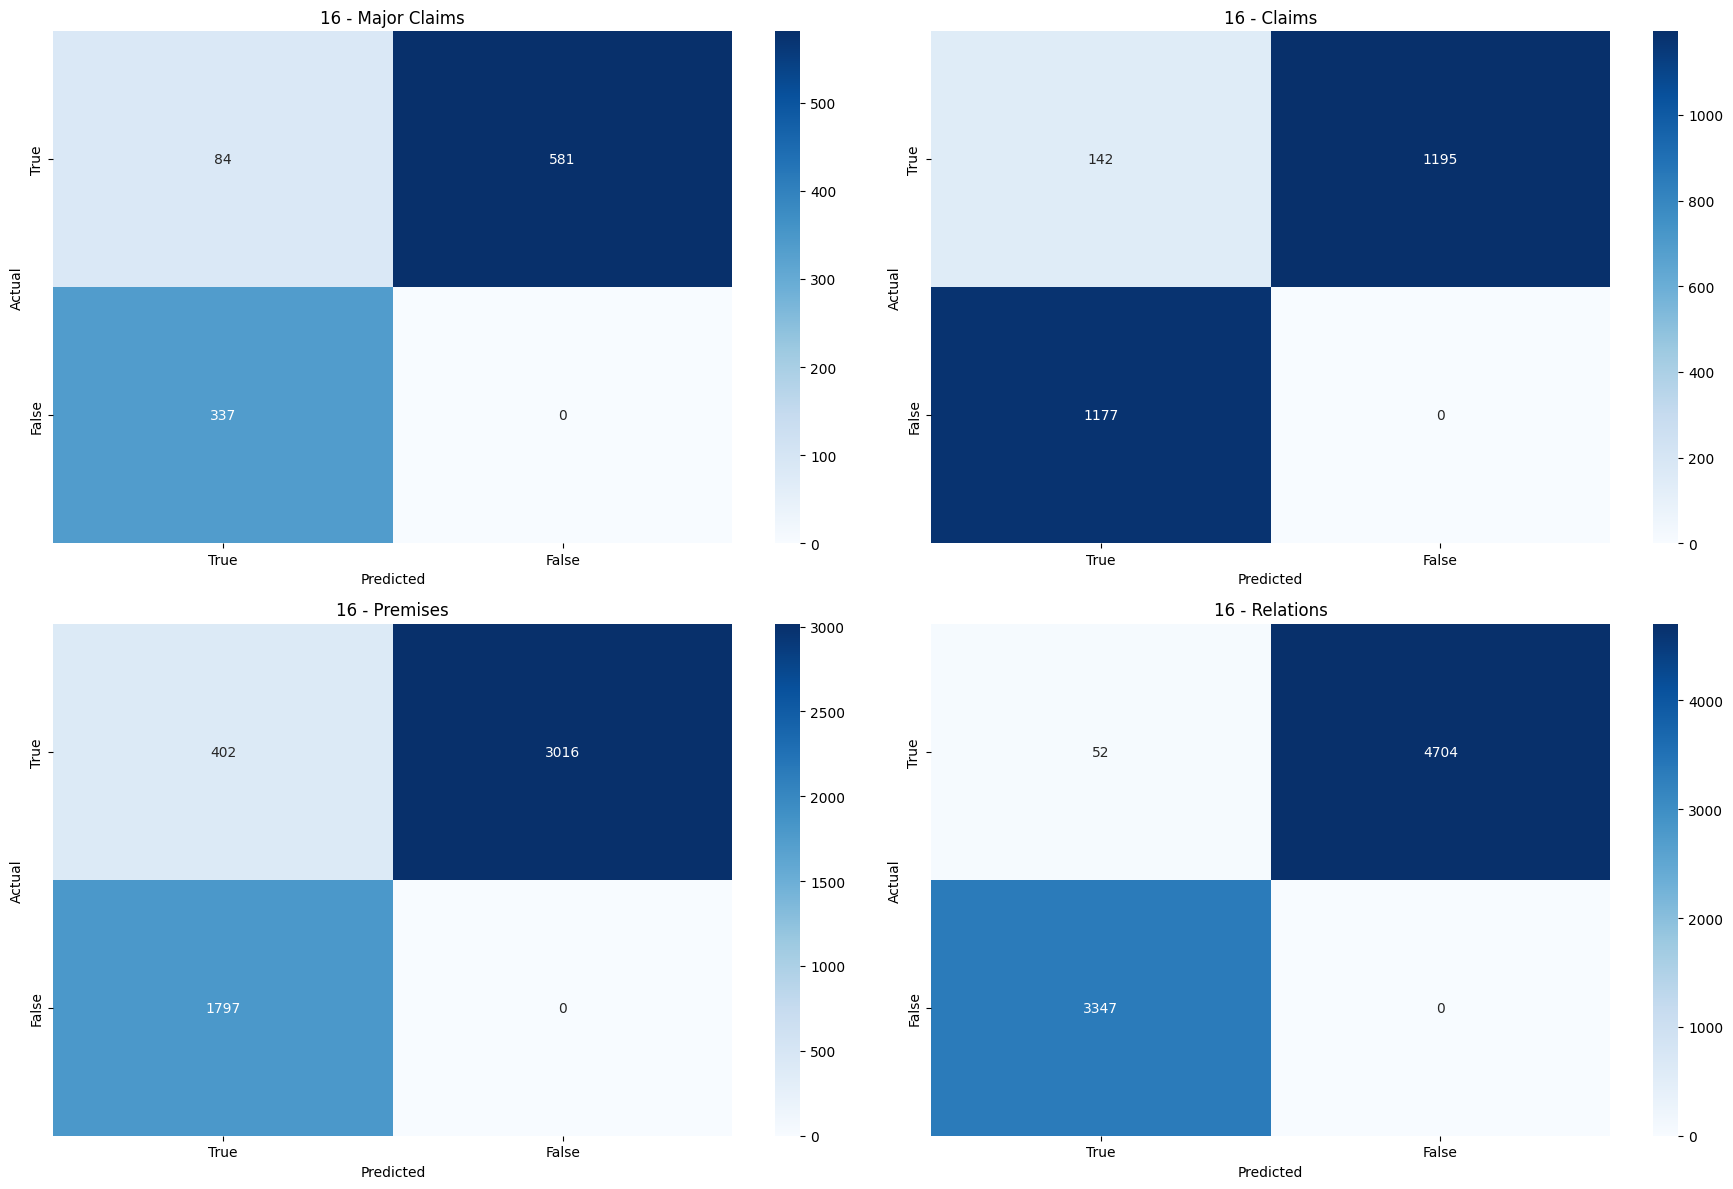

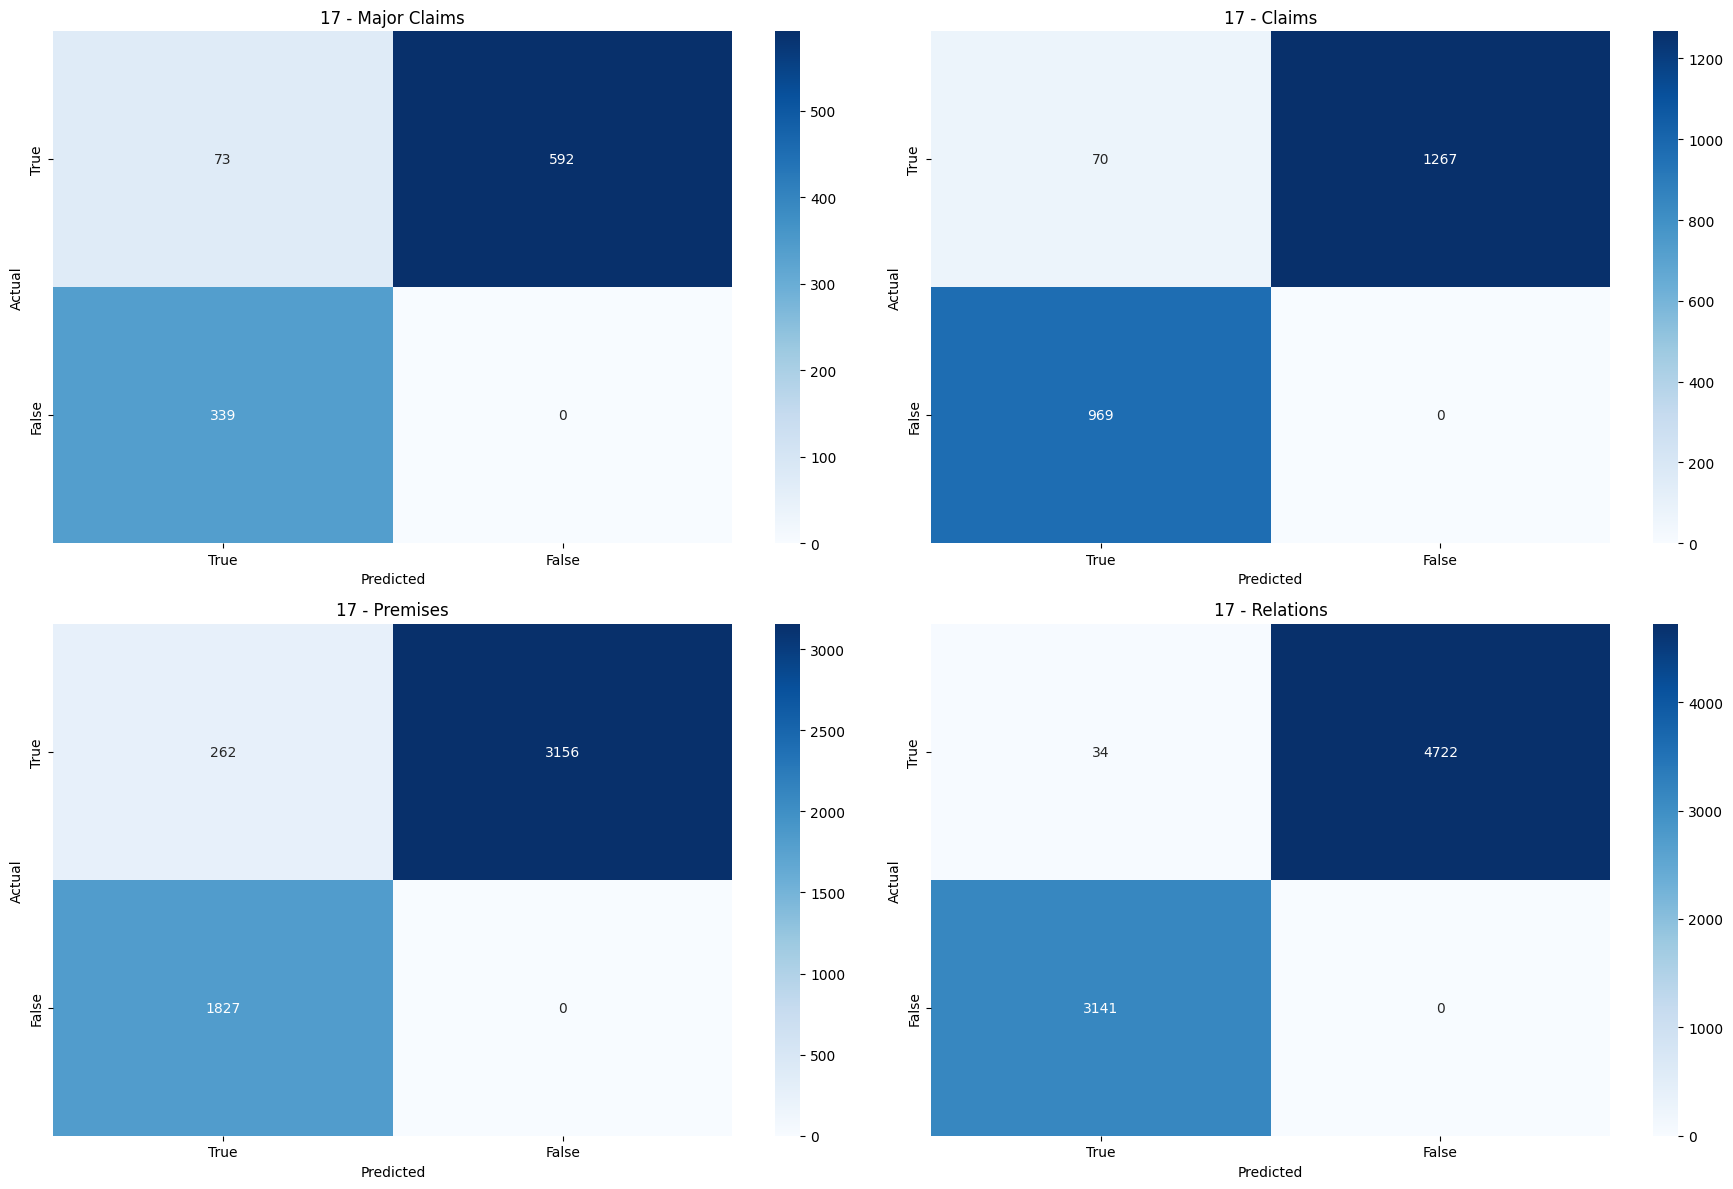

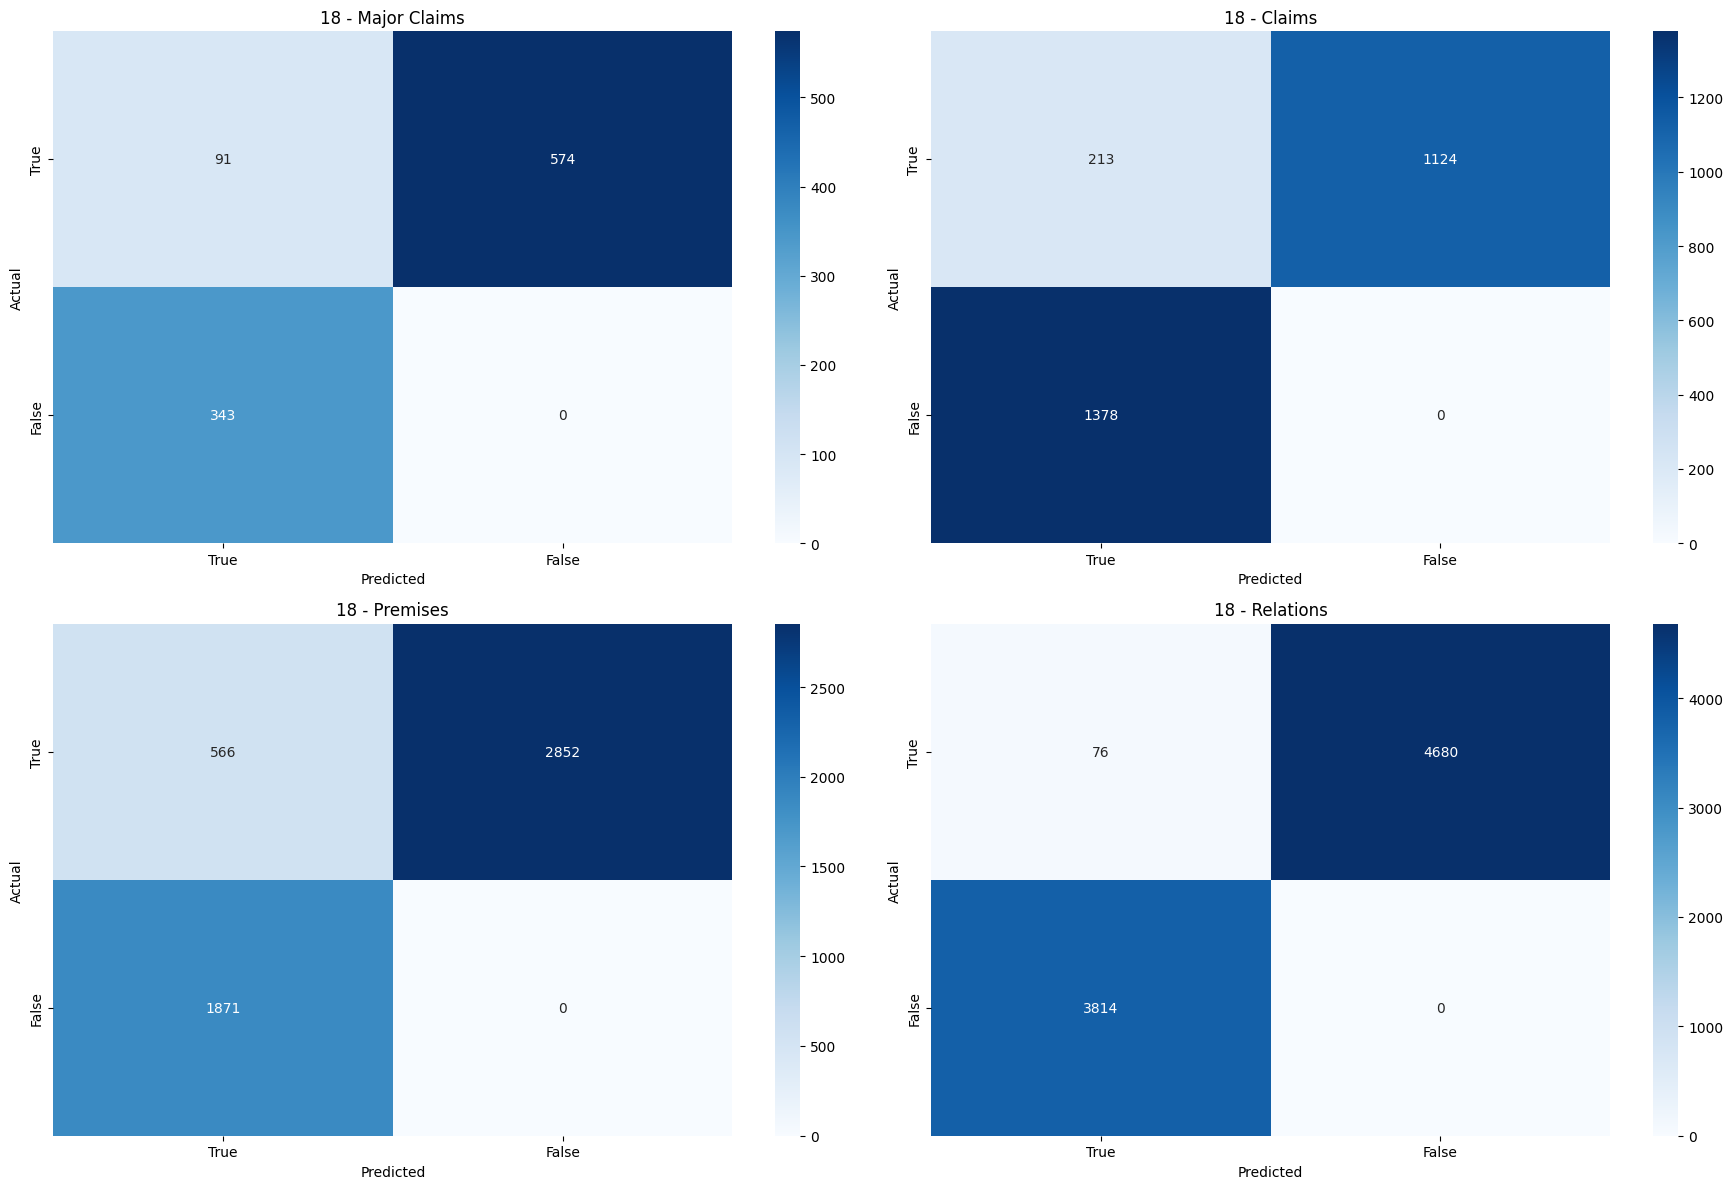

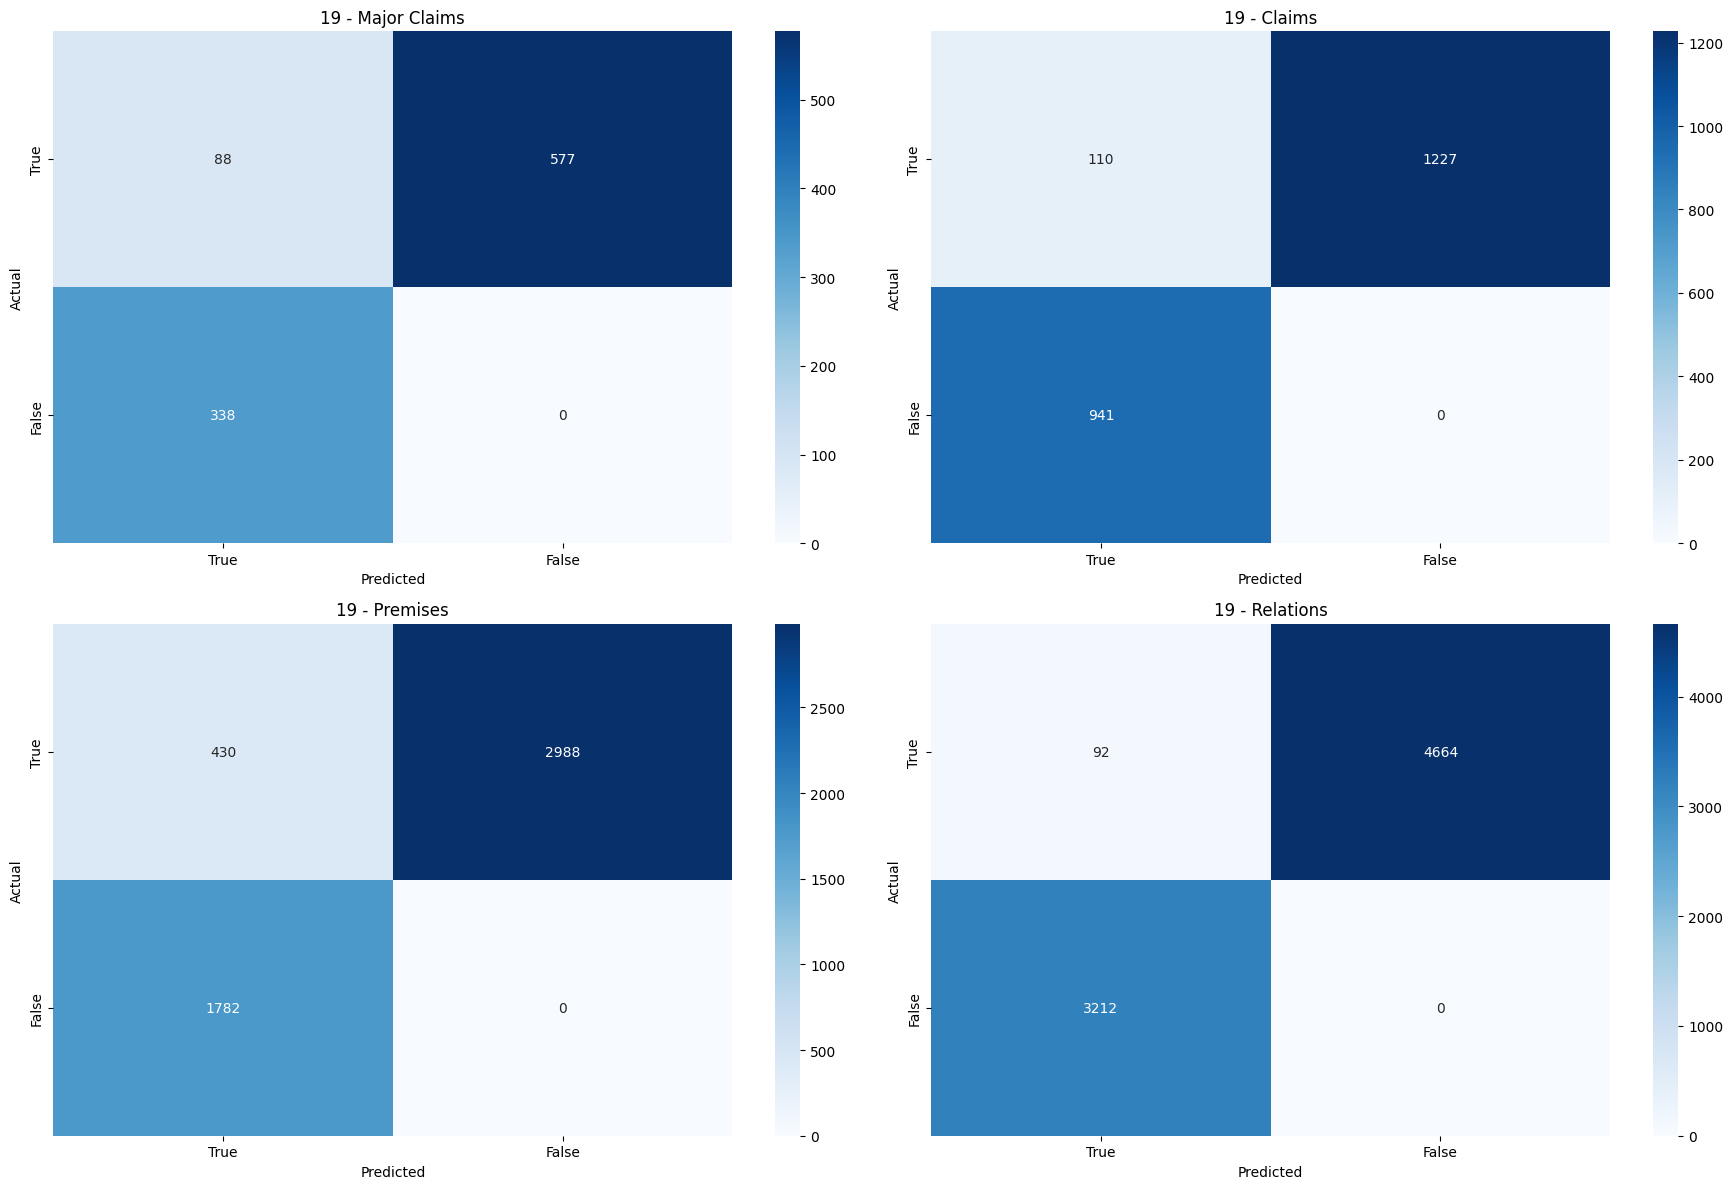

In [ ]:
plot_confusion_matrices(grouped_df)

# Evaluationsmetriken

In [24]:
# Anzahl der Tokens in pro Promptvariante bestimme,
PROMPTS_PATH = 'prompts/final-prompts/'

prompt_files_directory_list = list_files_with_extension_directory(PROMPTS_PATH, '.txt')
prompt_files_directory_list
prompt_files_list = [os.path.basename(x) for x in prompt_files_directory_list]
# entfernen der Dateiendung .txt, um nur den Dateinamen zu erhalten, welcher der Promptbezeichnung entspricht
prompt_names = [x.split('.')[0] for x in prompt_files_list]
# Erstellen des DataFrames mit den Prompts und der Anzahl der Tokens
token_df = pd.DataFrame()
token_df['Prompt'] = prompt_names
token_df['prompt_txt'] = prompt_files_directory_list # Pfad zur Datei
token_df['prompt_txt'] = token_df['prompt_txt'].apply(load_text) # Text aus Datei anhand des Pfades laden
token_df['tokens'] = token_df['prompt_txt'].apply(num_tokens_from_string, model_name='gpt-4o-mini') # Anzahl der Tokens aus Text bestimmen
token_df = token_df.drop(columns=['prompt_txt']) # Hilfsspalte entfernen
token_df = token_df.sort_values(by='tokens')
token_df

,Prompt,tokens
19,zero-shot,82
18,zero-shot-persona,105
16,zero-shot-cot,480
17,zero-shot-persona-cot,503
15,one-shot,1780
14,one-shot-persona,1790
12,one-shot-cot,2166
13,one-shot-persona-cot,2189
3,few-shot-10,13848
2,few-shot-10-persona,13871


## textweise Berechnung der Evaluationsmetriken

In [25]:
eval_metric_df = calc_mertics(merged_eval_df)
eval_metric_df.head()

,Prompt,Precision_MC,Recall_MC,F1_Score_MC,Precision_C,Recall_C,F1_Score_C,Precision_P,Recall_P,F1_Score_P,Precision_R,Recall_R,F1_Score_R
0,zero-shot,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00
1,zero-shot-persona,1.0,0.5,0.67,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00
2,zero-shot-cot,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00
3,zero-shot-persona-cot,1.0,0.5,0.67,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00
4,one-shot,1.0,0.5,0.67,1.0,0.8,0.89,1.0,0.47,0.64,0.42,0.22,0.29


In [26]:
# Hinzuügen der Anzahl der Tokens pro Prompt zu den Metriken anhand der Promptbezeichnung
eval_metric_df = pd.merge(eval_metric_df, token_df, on='Prompt')
print(eval_metric_df.shape)
eval_metric_df.sample(5, random_state=42)

(7180, 14)


,Prompt,Precision_MC,Recall_MC,F1_Score_MC,Precision_C,Recall_C,F1_Score_C,Precision_P,Recall_P,F1_Score_P,Precision_R,Recall_R,F1_Score_R,tokens
1554,few-shot-20-cot,0.5,0.5,0.5,0.14,0.25,0.18,0.62,0.36,0.45,0.13,0.11,0.12,28080
2876,few-shot-40,0.5,0.5,0.5,0.25,0.12,0.17,0.75,0.50,0.60,0.12,0.07,0.09,54048
1755,few-shot-20-persona-cot,1.0,1.0,1.0,0.33,0.67,0.44,0.25,0.17,0.20,0.00,0.00,0.00,28103
2505,one-shot-persona,0.0,0.0,0.0,0.29,0.50,0.36,1.00,0.43,0.60,0.10,0.09,0.10,1790
1335,few-shot-20-persona-cot,1.0,1.0,1.0,0.29,0.67,0.40,0.71,0.29,0.42,0.29,0.20,0.24,28103


In [27]:
# F1-Score für die Argumentationskomponenten und Beziehungen
eval_metric_df[['F1_Score_MC', 'F1_Score_C', 'F1_Score_P', 'F1_Score_R']].describe().round(2)

,F1_Score_MC,F1_Score_C,F1_Score_P,F1_Score_R
count,7180.00,7180.00,7180.00,7180.00
mean,0.44,0.27,0.32,0.09
std,0.37,0.22,0.22,0.12
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.14,0.00
50%,0.50,0.25,0.31,0.06
75%,0.67,0.43,0.48,0.15
max,1.00,1.00,1.00,0.76


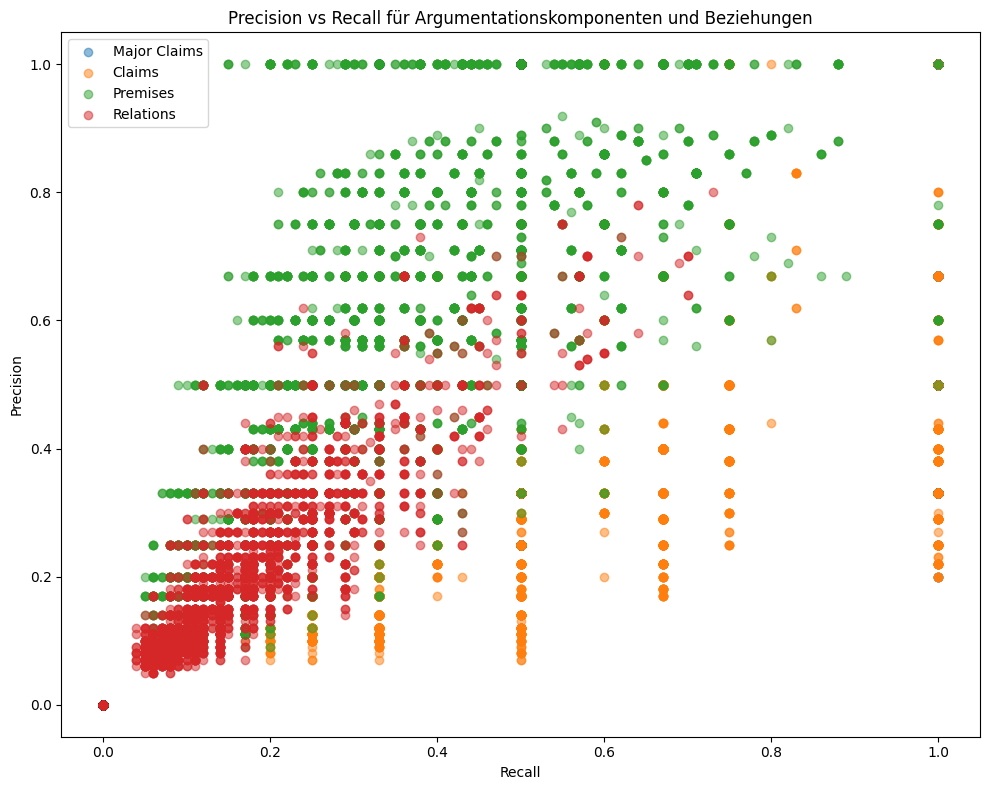

In [28]:
# Scatterplot für Precision und Recall
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(eval_metric_df['Recall_MC'], eval_metric_df['Precision_MC'], label='Major Claims', alpha=0.5) # Hauptaussagen
ax.scatter(eval_metric_df['Recall_C'], eval_metric_df['Precision_C'], label='Claims', alpha=0.5) # Behauptungen
ax.scatter(eval_metric_df['Recall_P'], eval_metric_df['Precision_P'], label='Premises', alpha=0.5) # Prämisse
ax.scatter(eval_metric_df['Recall_R'], eval_metric_df['Precision_R'], label='Relations', alpha=0.5) # Beziehungen
# Titel und Beschriftungen
ax.set_title('Precision vs Recall für Argumentationskomponenten und Beziehungen')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
plt.tight_layout()
plt.show()

## nach Prompt gruppierte Berechnung der Evaluationsmetriken

In [29]:
# Berechnung der Metriken für die Argumentationsstruktur pro Prompt
grouped_eval_metric_df = calc_mertics(grouped_df)
# Hinzufügen der Anzahl der Tokens pro Prompt zu den Metriken anhand der Promptbezeichnung
grouped_eval_metric_df = pd.merge(grouped_eval_metric_df, token_df, on='Prompt')
# Spalten mit dem F1-Score auf die zweiter Nachkommastelle runden
grouped_eval_metric_df[['F1_Score_MC', 'F1_Score_C', 'F1_Score_P', 'F1_Score_R']] = grouped_eval_metric_df[['F1_Score_MC', 'F1_Score_C', 'F1_Score_P', 'F1_Score_R']]
grouped_eval_metric_df[['Prompt', 'F1_Score_MC', 'F1_Score_C', 'F1_Score_P', 'F1_Score_R', 'tokens']].sort_values(by='tokens', ascending=False)

,Prompt,F1_Score_MC,F1_Score_C,F1_Score_P,F1_Score_R,tokens
11,few-shot-40-persona-cot,0.55,0.31,0.40,0.12,54470
9,few-shot-40-cot,0.53,0.30,0.40,0.11,54447
10,few-shot-40-persona,0.54,0.31,0.40,0.11,54071
8,few-shot-40,0.55,0.33,0.41,0.12,54048
7,few-shot-20-persona-cot,0.56,0.32,0.41,0.12,28103
5,few-shot-20-cot,0.53,0.30,0.39,0.11,28080
6,few-shot-20-persona,0.55,0.32,0.40,0.13,27704
4,few-shot-20,0.54,0.31,0.39,0.12,27681
3,few-shot-10-persona-cot,0.53,0.31,0.40,0.12,14270
1,few-shot-10-cot,0.51,0.29,0.38,0.11,14247


In [30]:
grouped_eval_metric_df[['F1_Score_MC', 'F1_Score_C', 'F1_Score_P', 'F1_Score_R']].describe().round(2)

,F1_Score_MC,F1_Score_C,F1_Score_P,F1_Score_R
count,20.00,20.00,20.00,20.00
mean,0.44,0.26,0.33,0.09
std,0.15,0.08,0.10,0.04
min,0.14,0.06,0.10,0.01
25%,0.43,0.27,0.30,0.08
50%,0.52,0.30,0.38,0.11
75%,0.54,0.31,0.40,0.12
max,0.56,0.33,0.41,0.13


In [31]:
# Gruppierung der Prompts nach Anzahl an Beispielen
zs_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("zero-shot")]
os_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("one-shot")]
fs10_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("few-shot-10")]
fs20_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("few-shot-20")]
fs40_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("few-shot-40")]

# Durchschnittliche Anzahl der Tokens pro Promptgruppe
zs_mean_tokens= round(zs_eval_metric_df['tokens'].mean(), 0)
os_mean_tokens= round(os_eval_metric_df['tokens'].mean(), 0)
fs10_mean_tokens= round(fs10_eval_metric_df['tokens'].mean(), 0)
fs20_mean_tokens= round(fs20_eval_metric_df['tokens'].mean(), 0)
fs40_mean_tokens= round(fs40_eval_metric_df['tokens'].mean(), 0)
print(f"Zero-Shot Mean Tokens: {zs_mean_tokens}")
print(f"One-Shot Mean Tokens: {os_mean_tokens}")
print(f"Few-Shot 10 Mean Tokens: {fs10_mean_tokens}")
print(f"Few-Shot 20 Mean Tokens: {fs20_mean_tokens}")
print(f"Few-Shot 40 Mean Tokens: {fs40_mean_tokens}")

Zero-Shot Mean Tokens: 292.0
One-Shot Mean Tokens: 1981.0
Few-Shot 10 Mean Tokens: 14059.0
Few-Shot 20 Mean Tokens: 27892.0
Few-Shot 40 Mean Tokens: 54259.0


In [32]:
# Bezugswerte berechnen
mc_baseline = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'] == 'zero-shot']['F1_Score_MC'].values[0]
c_baseline = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'] == 'zero-shot']['F1_Score_C'].values[0]
p_baseline = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'] == 'zero-shot']['F1_Score_P'].values[0]
r_baseline = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'] == 'zero-shot']['F1_Score_R'].values[0]
print(f"Hauptaussagen F1-Score Bezugswert: {mc_baseline}")
print(f"Behauptungen F1-Score Bezugswert: {c_baseline}")
print(f"Prämissen F1-Score Bezugswert: {p_baseline}")
print(f"Beziehungen F1-Score Bezugswert: {r_baseline}")

# Berechnung der Differenz zum Bezugswert absolut (F1-Score)
grouped_eval_metric_df['mc_diff_baseline'] = (grouped_eval_metric_df['F1_Score_MC'] - mc_baseline) 
grouped_eval_metric_df['c_diff_baseline'] = (grouped_eval_metric_df['F1_Score_C'] - c_baseline)
grouped_eval_metric_df['p_diff_baseline'] = (grouped_eval_metric_df['F1_Score_P'] - p_baseline)
grouped_eval_metric_df['r_diff_baseline'] = (grouped_eval_metric_df['F1_Score_R'] - r_baseline)
#Berechnung der Differenz zum Bezugswert (Baseline) in Prozent
grouped_eval_metric_df['mc_diff_baseline%'] = ((grouped_eval_metric_df['F1_Score_MC'] - mc_baseline) / mc_baseline * 100).round()
grouped_eval_metric_df['c_diff_baseline%'] = ((grouped_eval_metric_df['F1_Score_C'] - c_baseline) / c_baseline * 100).round()
grouped_eval_metric_df['p_diff_baseline%'] = ((grouped_eval_metric_df['F1_Score_P'] - p_baseline) / p_baseline * 100).round()
grouped_eval_metric_df['r_diff_baseline%'] = ((grouped_eval_metric_df['F1_Score_R'] - r_baseline) / r_baseline * 100).round()

grouped_eval_metric_df[['Prompt', 'F1_Score_MC', 'mc_diff_baseline', 'mc_diff_baseline%', 'F1_Score_C', 'c_diff_baseline', 'c_diff_baseline%', 'F1_Score_P', 'p_diff_baseline', 'p_diff_baseline%', 'F1_Score_R', 'r_diff_baseline', 'r_diff_baseline%', 'tokens']].sort_values(by='tokens', ascending=False)

Hauptaussagen F1-Score Bezugswert: 0.15
Behauptungen F1-Score Bezugswert: 0.11
Prämissen F1-Score Bezugswert: 0.14
Beziehungen F1-Score Bezugswert: 0.01


,Prompt,F1_Score_MC,mc_diff_baseline,mc_diff_baseline%,F1_Score_C,c_diff_baseline,c_diff_baseline%,F1_Score_P,p_diff_baseline,p_diff_baseline%,F1_Score_R,r_diff_baseline,r_diff_baseline%,tokens
11,few-shot-40-persona-cot,0.55,0.40,267.0,0.31,0.20,182.0,0.40,0.26,186.0,0.12,0.11,1100.0,54470
9,few-shot-40-cot,0.53,0.38,253.0,0.30,0.19,173.0,0.40,0.26,186.0,0.11,0.10,1000.0,54447
10,few-shot-40-persona,0.54,0.39,260.0,0.31,0.20,182.0,0.40,0.26,186.0,0.11,0.10,1000.0,54071
8,few-shot-40,0.55,0.40,267.0,0.33,0.22,200.0,0.41,0.27,193.0,0.12,0.11,1100.0,54048
7,few-shot-20-persona-cot,0.56,0.41,273.0,0.32,0.21,191.0,0.41,0.27,193.0,0.12,0.11,1100.0,28103
5,few-shot-20-cot,0.53,0.38,253.0,0.30,0.19,173.0,0.39,0.25,179.0,0.11,0.10,1000.0,28080
6,few-shot-20-persona,0.55,0.40,267.0,0.32,0.21,191.0,0.40,0.26,186.0,0.13,0.12,1200.0,27704
4,few-shot-20,0.54,0.39,260.0,0.31,0.20,182.0,0.39,0.25,179.0,0.12,0.11,1100.0,27681
3,few-shot-10-persona-cot,0.53,0.38,253.0,0.31,0.20,182.0,0.40,0.26,186.0,0.12,0.11,1100.0,14270
1,few-shot-10-cot,0.51,0.36,240.0,0.29,0.18,164.0,0.38,0.24,171.0,0.11,0.10,1000.0,14247


In [33]:
# Prompts nach Ergänzungen gruppieren
basic_list = ['zero-shot', 'one-shot', 'few-shot-10', 'few-shot-20', 'few-shot-40'] # ohne Ergänzung
persona_list = ['zero-shot-persona', 'one-shot-persona', 'few-shot-10-persona', 'few-shot-20-persona', 'few-shot-40-persona'] # mit Ergänzung Persona
cot_list = ['zero-shot-cot', 'one-shot-cot', 'few-shot-10-cot', 'few-shot-20-cot', 'few-shot-40-cot'] # mit Ergänzung COT
persona_cot_list = ['zero-shot-persona-cot', 'one-shot-persona-cot', 'few-shot-10-persona-cot', 'few-shot-20-persona-cot', 'few-shot-40-persona-cot'] # mit Ergänung Persona und COT

# Filtern der DataFrames nach den verschiedenen Prompt-Gruppen
eval_metric_basic_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(basic_list)].sort_values(by='tokens', ascending=False)
eval_metric_persona_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(persona_list)].sort_values(by='tokens', ascending=False)
eval_metric_cot_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(cot_list)].sort_values(by='tokens', ascending=False)
eval_metric_persona_cot_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(persona_cot_list)].sort_values(by='tokens', ascending=False)

In [34]:
eval_metric_basic_df

,Prompt,Precision_MC,Recall_MC,F1_Score_MC,Precision_C,Recall_C,F1_Score_C,Precision_P,Recall_P,F1_Score_P,...,F1_Score_R,tokens,mc_diff_baseline,c_diff_baseline,p_diff_baseline,r_diff_baseline,mc_diff_baseline%,c_diff_baseline%,p_diff_baseline%,r_diff_baseline%
8,few-shot-40,0.54,0.55,0.55,0.29,0.37,0.33,0.54,0.33,0.41,...,0.12,54048,0.40,0.22,0.27,0.11,267.0,200.0,193.0,1100.0
4,few-shot-20,0.52,0.56,0.54,0.27,0.36,0.31,0.50,0.32,0.39,...,0.12,27681,0.39,0.20,0.25,0.11,260.0,182.0,179.0,1100.0
0,few-shot-10,0.49,0.54,0.51,0.26,0.37,0.30,0.49,0.30,0.37,...,0.11,13848,0.36,0.19,0.23,0.10,240.0,173.0,164.0,1000.0
12,one-shot,0.41,0.44,0.43,0.20,0.39,0.27,0.39,0.24,0.30,...,0.08,1780,0.28,0.16,0.16,0.07,187.0,145.0,114.0,700.0
16,zero-shot,0.20,0.13,0.15,0.11,0.11,0.11,0.18,0.12,0.14,...,0.01,82,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0


# Abbildungen

## durchschnittlicher F1-Score für Argumentationskomponenten und Beziehungen pro Prompt

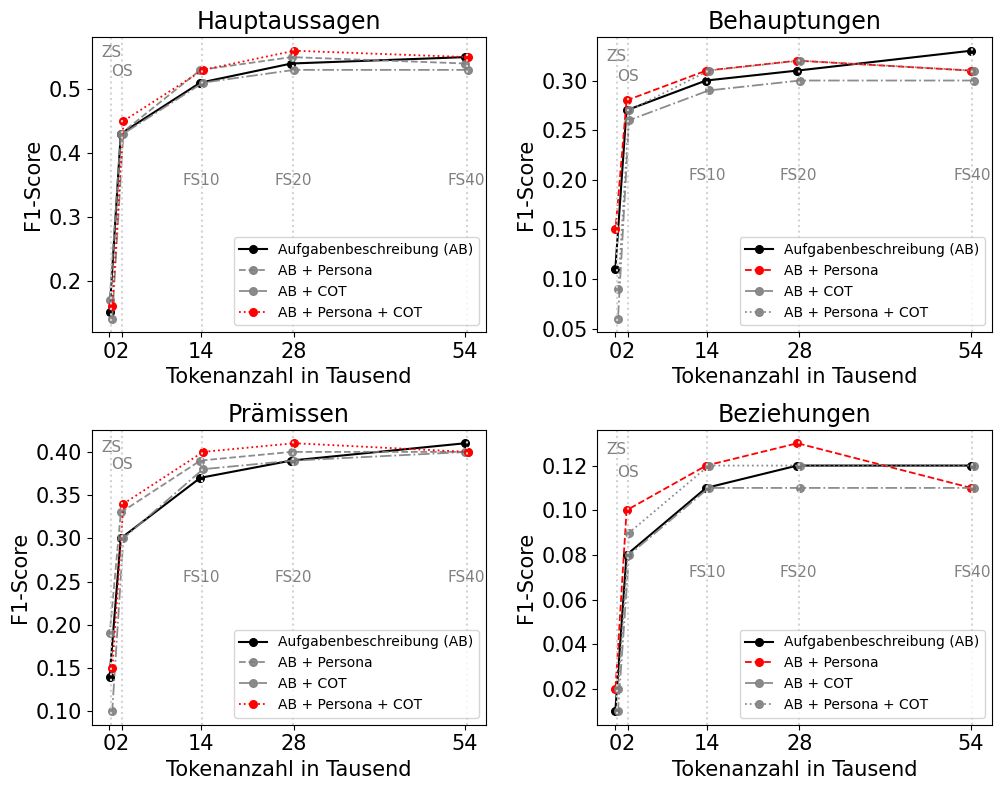

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Verwendung der auf Tausend gerundeten Tokenanzahl als Beschreibung der x-Achse.
# Die Beschriftungen stimmen absichtlich nicht mit den tatsächlichen Tokenanzahlen und den vertikalen Linien überein, um die Lesbarkeit zu verbessern bei gleichzeitiger korrekten Abbildung der Daten.
for ax in axs.flat:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}'))   
    ax.set_xticks([round(zs_mean_tokens, -3), round(os_mean_tokens, -3), round(fs10_mean_tokens, -3), round(fs20_mean_tokens, -3), round(fs40_mean_tokens, -3)]) 

# Formatierungeinstellungen
linecolor = 'grey'
ab_linecolor = 'black'
vertical_linecolor = 'lightgrey'
best_linecolor = 'red'
basic_linestyle = 'solid'
persona_linestyle = 'dashed'
cot_linestyle = 'dashdot'
persona_cot_linestyle = 'dotted'
linewidth_basic = 1.5
linewidth_rest = 1.3
label_fontsize = 15
title_fontsize = 17
annotation_fontsize = 11
annotation_color = 'grey'
legend_loc = 'lower right'
marker = "."
markersize = 11
alpha = 0.9

# Plot für Hauptaussagen
axs[0, 0].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_MC'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=ab_linecolor)
axs[0, 0].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_MC'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=linecolor,
               alpha=alpha)
axs[0, 0].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_MC'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle, linewidth=linewidth_rest,
               color=linecolor,
               alpha=alpha)
axs[0, 0].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_MC'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=best_linecolor)
axs[0, 0].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[0, 0].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[0, 0].set_title('Hauptaussagen', fontsize=title_fontsize)
axs[0, 0].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[0, 0].legend(loc=legend_loc)
# vertikale Linien
axs[0, 0].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[0, 0].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[0, 0].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[0, 0].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[0, 0].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[0, 0].annotate('ZS', xy=(zs_mean_tokens, 0.5), xytext=(zs_mean_tokens, 0.55), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('OS', xy=(os_mean_tokens, 0.5), xytext=(os_mean_tokens, 0.52), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('FS10', xy=(fs10_mean_tokens, 0.35), xytext=(fs10_mean_tokens, 0.35), xycoords='data', fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('FS20', xy=(fs20_mean_tokens, 0.35), xytext=(fs20_mean_tokens, 0.35), xycoords='data' , fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('FS40', xy=(fs40_mean_tokens, 0.35), xytext=(fs40_mean_tokens, 0.35), xycoords='data' , fontsize=annotation_fontsize, color=annotation_color, ha='center')

# Plot für Behauptungen
axs[0, 1].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_C'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=ab_linecolor)
axs[0, 1].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_C'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=best_linecolor)
axs[0, 1].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_C'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle, linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[0, 1].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_C'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[0, 1].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[0, 1].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[0, 1].set_title('Behauptungen', fontsize=title_fontsize)
axs[0, 1].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[0, 1].legend(loc=legend_loc)
# vertikale Linien
axs[0, 1].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[0, 1].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[0, 1].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[0, 1].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[0, 1].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[0, 1].annotate(text='ZS', xy=(zs_mean_tokens, 0.31), xytext=(zs_mean_tokens, 0.32), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='OS', xy=(os_mean_tokens, 0.31), xytext=(os_mean_tokens, 0.3), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='FS10', xy=(fs10_mean_tokens, 0.2), xytext=(fs10_mean_tokens, 0.2), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='FS20', xy=(fs20_mean_tokens, 0.2), xytext=(fs20_mean_tokens, 0.2), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='FS40', xy=(fs40_mean_tokens, 0.2), xytext=(fs40_mean_tokens, 0.2), fontsize=annotation_fontsize, color=annotation_color, ha='center')

# Plot für Prämissen
axs[1, 0].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_P'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=ab_linecolor)
axs[1, 0].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_P'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[1, 0].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_P'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle,
               linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[1, 0].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_P'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=best_linecolor)
axs[1, 0].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[1, 0].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[1, 0].set_title('Prämissen', fontsize=title_fontsize)
axs[1, 0].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[1, 0].legend(loc=legend_loc)
# vertikale Linien
axs[1, 0].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[1, 0].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[1, 0].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[1, 0].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[1, 0].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[1, 0].annotate('ZS', xy=(zs_mean_tokens, 0.4), xytext=(zs_mean_tokens, 0.4), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('OS', xy=(os_mean_tokens, 0.4), xytext=(os_mean_tokens, 0.38), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('FS10', xy=(fs10_mean_tokens, 0.25), xytext=(fs10_mean_tokens, 0.25), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('FS20', xy=(fs20_mean_tokens, 0.25), xytext=(fs20_mean_tokens, 0.25), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('FS40', xy=(fs40_mean_tokens, 0.25), xytext=(fs40_mean_tokens, 0.25), fontsize=annotation_fontsize, color=annotation_color, ha='center')

# Plot für Beziehungen
axs[1, 1].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_R'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=ab_linecolor)
axs[1, 1].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_R'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=best_linecolor)
axs[1, 1].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_R'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle, linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[1, 1].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_R'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[1, 1].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[1, 1].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[1, 1].set_title('Beziehungen', fontsize=title_fontsize)
axs[1, 1].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[1, 1].legend(loc=legend_loc)
# vertikale Linien
axs[1, 1].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[1, 1].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[1, 1].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[1, 1].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[1, 1].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[1, 1].annotate('ZS', xy=(zs_mean_tokens, 0.12), xytext=(zs_mean_tokens, 0.125), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('OS', xy=(os_mean_tokens, 0.12), xytext=(os_mean_tokens, 0.115), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('FS10', xy=(fs10_mean_tokens, 0.07), xytext=(fs10_mean_tokens, 0.07), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('FS20', xy=(fs20_mean_tokens, 0.07), xytext=(fs20_mean_tokens, 0.07), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('FS40', xy=(fs40_mean_tokens, 0.07), xytext=(fs40_mean_tokens, 0.07), fontsize=annotation_fontsize, color=annotation_color, ha='center')

plt.tight_layout()
plt.show()

## absolute Abweichung der F1-Scores vom Bezugswert

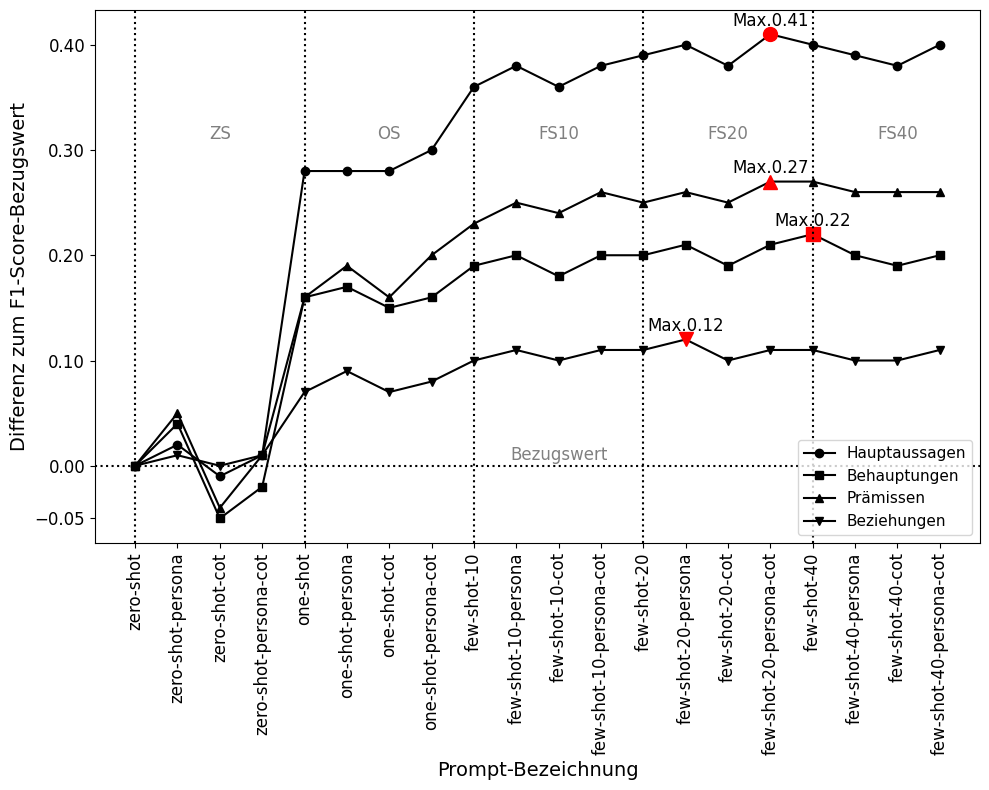

In [36]:
fig, ax = plt.subplots(figsize=(10, 8)) 

# Formatierungeinstellungen
linecolor = 'black'
annotation_color = 'grey'
highlight_color = 'red'
grouped_eval_metric_df.sort_values(by='tokens', ascending=True, inplace=True) # gewünschte Reihenfolge sicherstellen

# absolute Abweichung der F1-Scores vom Bezugswert für die Argumentationskomponenten und Beziehungen plotten
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['mc_diff_baseline'], label='Hauptaussagen', marker='o', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['c_diff_baseline'], label='Behauptungen', marker='s', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['p_diff_baseline'], label='Prämissen', marker='^', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['r_diff_baseline'], label='Beziehungen', marker='v', color=linecolor)

# Markierung der Maximalwerte für MC, C. P, R
max_mc = grouped_eval_metric_df.loc[grouped_eval_metric_df['mc_diff_baseline'].idxmax()]
max_c = grouped_eval_metric_df.loc[grouped_eval_metric_df['c_diff_baseline'].idxmax()]
max_p = grouped_eval_metric_df.loc[grouped_eval_metric_df['p_diff_baseline'].idxmax()]
max_r = grouped_eval_metric_df.loc[grouped_eval_metric_df['r_diff_baseline'].idxmax()]
ax.plot(max_mc['Prompt'], max_mc['mc_diff_baseline'], 'o', markersize=10, color=highlight_color)
ax.plot(max_c['Prompt'], max_c['c_diff_baseline'], 's', markersize=10, color=highlight_color)
ax.plot(max_p['Prompt'], max_p['p_diff_baseline'], '^', markersize=10, color=highlight_color)
ax.plot(max_r['Prompt'], max_r['r_diff_baseline'], 'v', markersize=10, color=highlight_color)
ax.annotate(f'Max.{max_mc["mc_diff_baseline"]:.2f}', xy=(max_mc['Prompt'], max_mc['mc_diff_baseline']), xytext=(max_mc['Prompt'], max_mc['mc_diff_baseline'] + 0.008), fontsize=12, ha='center', color=linecolor)
ax.annotate(f'Max.{max_c["c_diff_baseline"]:.2f}', xy=(max_c['Prompt'], max_c['c_diff_baseline']), xytext=(max_c['Prompt'], max_c['c_diff_baseline'] + 0.008), fontsize=12, ha='center', color=linecolor)
ax.annotate(f'Max.{max_p["p_diff_baseline"]:.2f}', xy=(max_p['Prompt'], max_p['p_diff_baseline']), xytext=(max_p['Prompt'], max_p['p_diff_baseline'] + 0.008), fontsize=12, ha='center', color=linecolor)
ax.annotate(f'Max.{max_r["r_diff_baseline"]:.2f}', xy=(max_r['Prompt'], max_r['r_diff_baseline']), xytext=(max_r['Prompt'], max_r['r_diff_baseline'] + 0.008), fontsize=12, ha='center', color=linecolor)

# vertikale Linien für die verschiedenen Prompt-Gruppen
plt.axvline(x='zero-shot', color=linecolor, linestyle='dotted')
plt.axvline(x='one-shot', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-10', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-20', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-40', color=linecolor, linestyle='dotted')
plt.axhline(y=0, color=linecolor, linestyle='dotted')

# Beschriftungen für die vertikalen Linien
plt.annotate('ZS', xy=('zero-shot', 0.31), xytext=('zero-shot-cot', 0.31), fontsize=12, ha='center', color=annotation_color)
plt.annotate('OS', xy=('one-shot', 0.31), xytext=('one-shot-cot', 0.31), fontsize=12, ha='center', color=annotation_color)
plt.annotate('FS10', xy=('few-shot-10', 0.31), xytext=('few-shot-10-cot', 0.31), fontsize=12, ha='center', color=annotation_color)
plt.annotate('FS20', xy=('few-shot-20', 0.31), xytext=('few-shot-20-cot', 0.31), fontsize=12, ha='center', color=annotation_color)
plt.annotate('FS40', xy=('few-shot-40', 0.31), xytext=('few-shot-40-cot', 0.31), fontsize=12, ha='center', color=annotation_color)
plt.annotate('Bezugswert', xy=('zero-shot', 0), xytext=('few-shot-10-cot', 0.005), fontsize=12, ha='center', color=annotation_color)

# Titel und Beschriftungen
ax.set_xlabel('Prompt-Bezeichnung', fontsize=14)
ax.set_ylabel('Differenz zum F1-Score-Bezugswert', fontsize=14)
ax.tick_params(axis='x', rotation=90, labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks([-0.05, 0, 0.1, 0.2, 0.3, 0.4], fontsize=12) # Anpassung der Beschriftung auf der y-Achse
ax.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.show()

## prozentuale Abweichung der F1-Scores vom Bezugswert

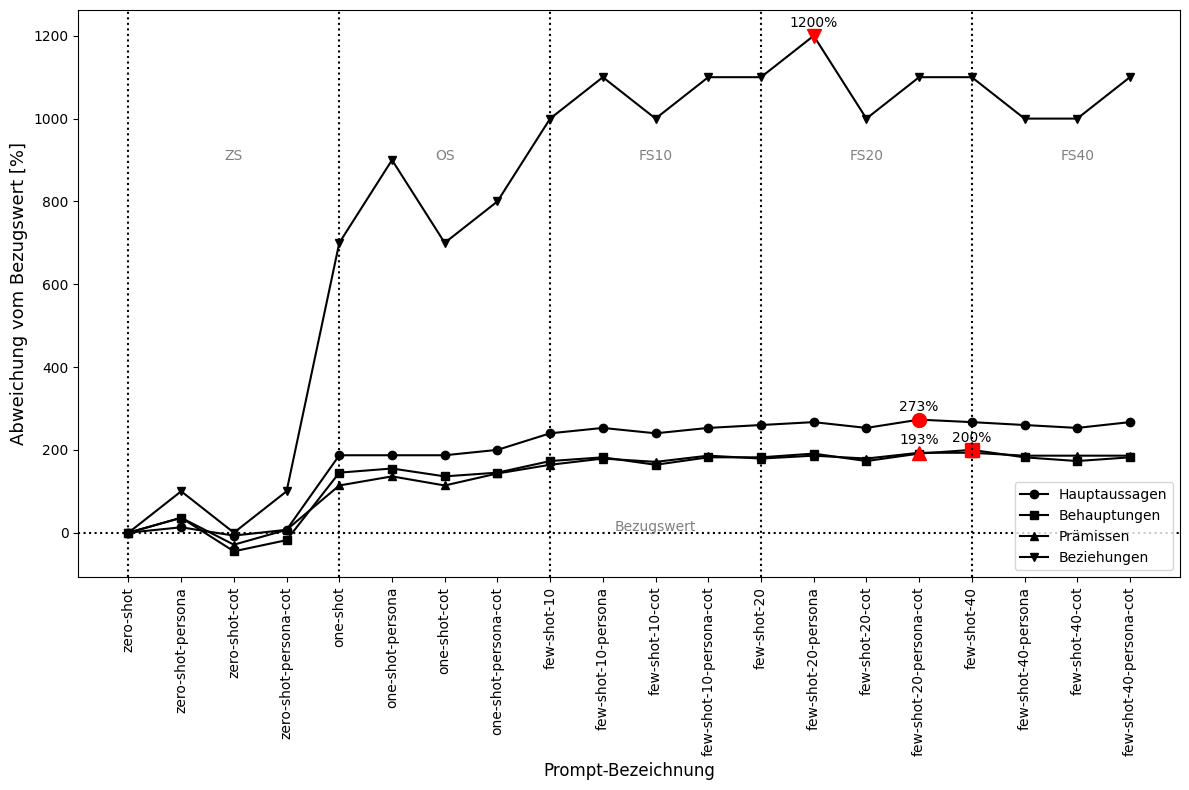

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))

linecolor = 'black'
annotation_color = 'grey'
highlight_color = 'red'
grouped_eval_metric_df.sort_values(by='tokens', ascending=True, inplace=True)
# prozentuale Abweichung der F1-Scores vom Bezugswert für die Argumentationskomponenten und Beziehungen plotten
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['mc_diff_baseline%'], label='Hauptaussagen', marker='o', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['c_diff_baseline%'], label='Behauptungen', marker='s', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['p_diff_baseline%'], label='Prämissen', marker='^', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['r_diff_baseline%'], label='Beziehungen', marker='v', color=linecolor)

# Markierung der Maximalwerte für MC, C. P, R
max_mc = grouped_eval_metric_df.loc[grouped_eval_metric_df['mc_diff_baseline%'].idxmax()]
max_c = grouped_eval_metric_df.loc[grouped_eval_metric_df['c_diff_baseline%'].idxmax()]
max_p = grouped_eval_metric_df.loc[grouped_eval_metric_df['p_diff_baseline%'].idxmax()]
max_r = grouped_eval_metric_df.loc[grouped_eval_metric_df['r_diff_baseline%'].idxmax()]
ax.plot(max_mc['Prompt'], max_mc['mc_diff_baseline%'], 'o', markersize=10, color=highlight_color)
ax.plot(max_c['Prompt'], max_c['c_diff_baseline%'], 's', markersize=10, color=highlight_color)
ax.plot(max_p['Prompt'], max_p['p_diff_baseline%'], '^', markersize=10, color=highlight_color)
ax.plot(max_r['Prompt'], max_r['r_diff_baseline%'], 'v', markersize=10, color=highlight_color)
ax.annotate(f'{int(max_mc["mc_diff_baseline%"])}%', xy=(max_mc['Prompt'], max_mc['mc_diff_baseline%']), xytext=(max_mc['Prompt'], max_mc['mc_diff_baseline%'] + 20), fontsize=10, ha='center', color=linecolor)
ax.annotate(f'{int(max_c["c_diff_baseline%"])}%', xy=(max_c['Prompt'], max_c['c_diff_baseline%']), xytext=(max_c['Prompt'], max_c['c_diff_baseline%'] + 20), fontsize=10, ha='center', color=linecolor)
ax.annotate(f'{int(max_p["p_diff_baseline%"])}%', xy=(max_p['Prompt'], max_p['p_diff_baseline%']), xytext=(max_p['Prompt'], max_p['p_diff_baseline%'] + 20), fontsize=10, ha='center', color=linecolor)
ax.annotate(f'{int(max_r["r_diff_baseline%"])}%', xy=(max_r['Prompt'], max_r['r_diff_baseline%']), xytext=(max_r['Prompt'], max_r['r_diff_baseline%'] + 20), fontsize=10, ha='center', color=linecolor)

# Vertikale Linien für die verschiedenen Prompt-Gruppen
plt.axvline(x='zero-shot', color=linecolor, linestyle='dotted')
plt.axvline(x='one-shot', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-10', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-20', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-40', color=linecolor, linestyle='dotted')
plt.axhline(y=0, color=linecolor, linestyle='dotted')

# Beschriftungen für die vertikalen Linien
plt.annotate('ZS', xy=('zero-shot', 900), xytext=('zero-shot-cot', 900), fontsize=10, ha='center', color=annotation_color)
plt.annotate('OS', xy=('one-shot', 900), xytext=('one-shot-cot', 900), fontsize=10, ha='center', color=annotation_color)
plt.annotate('FS10', xy=('few-shot-10', 900), xytext=('few-shot-10-cot', 900), fontsize=10, ha='center', color=annotation_color)
plt.annotate('FS20', xy=('few-shot-20', 900), xytext=('few-shot-20-cot', 900), fontsize=10, ha='center', color=annotation_color)
plt.annotate('FS40', xy=('few-shot-40', 900), xytext=('few-shot-40-cot', 900), fontsize=10, ha='center', color=annotation_color)
plt.annotate('Bezugswert', xy=('zero-shot', 0), xytext=('few-shot-10-cot', 5), fontsize=10, ha='center', color=annotation_color)

# Titel und Beschriftungen
ax.set_xlabel('Prompt-Bezeichnung', fontsize=12)
ax.set_ylabel('Abweichung vom Bezugswert [%]', fontsize=13)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='both', which='major')
# Gitterlinien bei Bedarf hinzufügen
# plt.grid(axis='y', linestyle='--')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# F1-Score pro Token bestimmen

In [38]:
# Dataframe mit Tokenanzahl und F1-Score für jeden Prompt erstellen
f1_per_token_df = grouped_eval_metric_df[['Prompt', 'tokens', 'F1_Score_MC', 'F1_Score_C', 'F1_Score_P', 'F1_Score_R']].copy()
# F1-Score pro 1.000 Tokens für die Prompts berechnen
f1_per_token_df['F1_Score_MC_per_token'] = round(f1_per_token_df['F1_Score_MC'] / (f1_per_token_df['tokens'] / 1000), 2)
f1_per_token_df['F1_Score_C_per_token'] = round(f1_per_token_df['F1_Score_C'] / (f1_per_token_df['tokens'] / 1000), 2)
f1_per_token_df['F1_Score_P_per_token'] = round(f1_per_token_df['F1_Score_P'] / (f1_per_token_df['tokens'] / 1000), 2)
f1_per_token_df['F1_Score_R_per_token'] = round(f1_per_token_df['F1_Score_R'] / (f1_per_token_df['tokens'] / 1000), 2)

f1_per_token_df[['Prompt', 'tokens', 'F1_Score_MC_per_token', 'F1_Score_C_per_token', 'F1_Score_P_per_token', 'F1_Score_R_per_token']]

,Prompt,tokens,F1_Score_MC_per_token,F1_Score_C_per_token,F1_Score_P_per_token,F1_Score_R_per_token
16,zero-shot,82,1.83,1.34,1.71,0.12
18,zero-shot-persona,105,1.62,1.43,1.81,0.19
17,zero-shot-cot,480,0.29,0.12,0.21,0.02
19,zero-shot-persona-cot,503,0.32,0.18,0.30,0.04
12,one-shot,1780,0.24,0.15,0.17,0.04
14,one-shot-persona,1790,0.24,0.16,0.18,0.06
13,one-shot-cot,2166,0.20,0.12,0.14,0.04
15,one-shot-persona-cot,2189,0.21,0.12,0.16,0.04
0,few-shot-10,13848,0.04,0.02,0.03,0.01
2,few-shot-10-persona,13871,0.04,0.02,0.03,0.01


In [39]:
f1_per_token_df.set_index('Prompt', inplace=True) # Prompt-Spalte als Index setzen
# Prompt mit dem höchsten F1-Score pro 1.000 Tokens  mit dem dazu gehörigen Wert
max_f1_per_token_mc = f1_per_token_df['F1_Score_MC_per_token'].idxmax()
max_f1_per_token_c = f1_per_token_df['F1_Score_C_per_token'].idxmax()
max_f1_per_token_p = f1_per_token_df['F1_Score_P_per_token'].idxmax()
max_f1_per_token_r = f1_per_token_df['F1_Score_R_per_token'].idxmax()
max_f1_per_token_mc_value = f1_per_token_df['F1_Score_MC_per_token'].max()
max_f1_per_token_c_value = f1_per_token_df['F1_Score_C_per_token'].max()
max_f1_per_token_p_value = f1_per_token_df['F1_Score_P_per_token'].max()
max_f1_per_token_r_value = f1_per_token_df['F1_Score_R_per_token'].max()
print("Prompt mit dem höchsten F1-Score pro 1.000 Tokens:")
print(f'für Hauptaussagen: {max_f1_per_token_mc} mit {max_f1_per_token_mc_value}')
print(f'für Behauptungen: {max_f1_per_token_c} mit {max_f1_per_token_c_value}')
print(f'für Prämissen: {max_f1_per_token_p} mit {max_f1_per_token_p_value}')
print(f'für Beziehungen: {max_f1_per_token_r} mit {max_f1_per_token_r_value}')

Prompt mit dem höchsten F1-Score pro 1.000 Tokens:
für Hauptaussagen: zero-shot mit 1.83
für Behauptungen: zero-shot-persona mit 1.43
für Prämissen: zero-shot-persona mit 1.81
für Beziehungen: zero-shot-persona mit 0.19


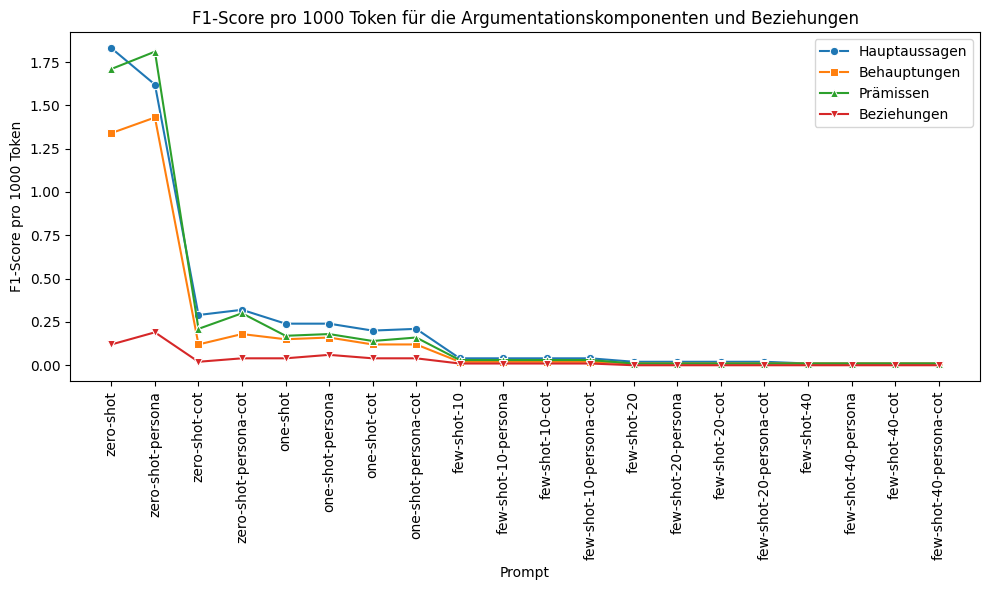

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Prompt', y='F1_Score_MC_per_token', data=f1_per_token_df, ax=ax, label='Hauptaussagen', marker='o')
sns.lineplot(x='Prompt', y='F1_Score_C_per_token', data=f1_per_token_df, ax=ax, label='Behauptungen', marker='s')
sns.lineplot(x='Prompt', y='F1_Score_P_per_token', data=f1_per_token_df, ax=ax, label='Prämissen', marker='^')
sns.lineplot(x='Prompt', y='F1_Score_R_per_token', data=f1_per_token_df, ax=ax, label='Beziehungen', marker='v')

# Titel und Beschriftungen
ax.set_title('F1-Score pro 1000 Token für die Argumentationskomponenten und Beziehungen')
ax.set_xlabel('Prompt')
ax.set_ylabel('F1-Score pro 1000 Token')
ax.tick_params(axis='x', rotation=90)
ax.legend()
plt.tight_layout()
plt.show()